# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 18

In [2]:
cluster = '18'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 237
Num noneffect sequences: 237


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
175   chr2  127128581  127128582   rs13025717      T         C   C      T   
103  chr17   75088242   75088243   rs55827552      A         G   A      G   
218   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
190   chr3   49007333   49007334    rs6781790      T         C   C      T   
198   chr4     960458     960459    rs3733345      T         G   G    A,T   
164  chr19   45326123   45326124     rs344792      A         G   G      A   
165  chr19   45326535   45326536     rs344791      C         G   G      C   
68   chr17   45894775   45894776   rs11575896      G         A   G      A   
106  chr17   78426790   78426791   rs72914885      C         A   A      C   
137  chr19   44905578   44905579     rs405509      G         T   T      G   
79   chr17   45947195   45947196   rs62062785      T         G   G    A,T   
220   chr5  103120549  103120550      rs26523      T         C   C      T   
85   chr17   46002354   46002355   rs62064662      G         A   A      G   
54   chr17    5235008    5235009   rs75511804      T         C   C      T   
169   chr2  127107344  127107345   rs76516995      C         G   C    A,G   
16   chr11   86067881   86067882     rs544458      C         T   C      T   
77   chr17   45942313   45942314   rs62062770      T         C   T      C   
70   chr17   45914521   45914522   rs55682376      G         A   G      A   
43   chr16   31033575   31033576   rs12445650      G         A   G      A   
20   chr11   86103987   86103988    rs1237999      A         G   G      A   
66   chr17   45894418   45894419   rs11575895      G         A   A      G   
22   chr11   86141936   86141937   rs10792831      A         G   G      A   
92   chr17   46143983   46143984    rs2532307      A         G   G    A,C   
97   chr17   58332679   58332680    rs2526377    NAN       NAN   A      G   
74   chr17   45935548   45935549   rs77924424      T         C   T      C   
140  chr19   44911193   44911194     rs439401      T         C   T      C   
156  chr19   45001918   45001919   rs35194062      A         C   C      A   
33   chr14   67517387   67517388    rs7144333      T         C   C    G,T   
230   chr7  100198448  100198449    rs3823642      C         T   T      C   
158  chr19   45040528   45040529    rs1560725      C         T   C      T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
124  chr19   44846144   44846145    rs3810143      C         T   T    C,G   
128  chr19   44856328   44856329   rs56317818      T         C   C    G,T   
135  chr19   44891078   44891079   rs71352238      C         T   T      C   
227   chr7   23106492   23106493    rs2072368      T         C   C      T   
38   chr15   78944950   78944951    rs2289702      T         C   C      T   
129  chr19   44856409   44856410   rs41289514      A         G   A    C,G   
148  chr19   44954888   44954889    rs3760629      C         A   A      C   
173   chr2  127107523  127107524   rs13032148      A         G   G      A   
201   chr4     973550     973551  rs113075206      G         C   C      G   
60   chr17   45826118   45826119   rs62057148      G         C   G    A,C   
82   chr17   45949128   45949129   rs74531363      G         A   A    G,T   
122  chr19   44845919   44845920   rs77241309      C         G   G      C   
160  chr19   45045876   45045877  rs112481437      A         G   G      A   
51   chr17    4909107    4909108   rs16954243      A         T   A      T   
168   chr2  127082204  127082205   rs10194375      A         C   C    A,T   
1     chr1  171742011  171742012   rs12119232      C         A   A      C   
177   chr2  127135191  127135192   rs34779859      G         T   G    A,T   
63   chr17   45894090   45894091   rs76594404      G         C   G    A,C   
235   chr8   22623005   22623006   rs11780207      G         A   G      A   
121  chr19   44844995   44844996   rs10426423      T         C   C  A,G,T   
75 

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 175   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9737   ||   Center / 200bp : 0.5703
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


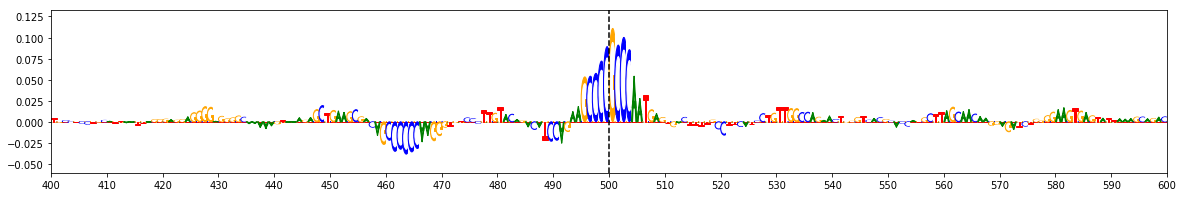

Effect Allele : T   ||   Explain Score : 0.3662   ||   Center / 200bp : 0.3331
Effect Sequence : CAGAAGCCCTGCCCAATGAG


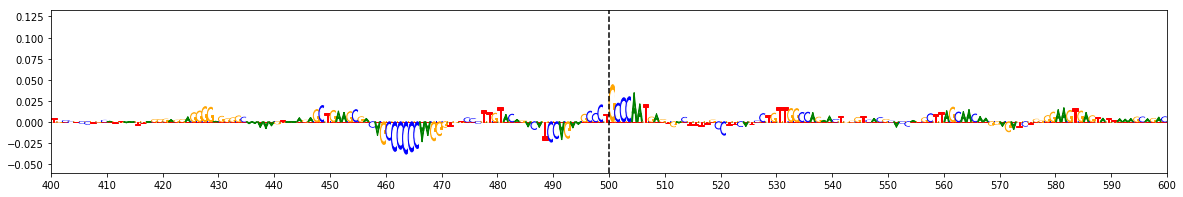

Allele Ratio : 0.376   ||   Allele Difference : -0.6213  ||  ISM Score : -0.9688  ||  deltaSVM Score : -5.5093


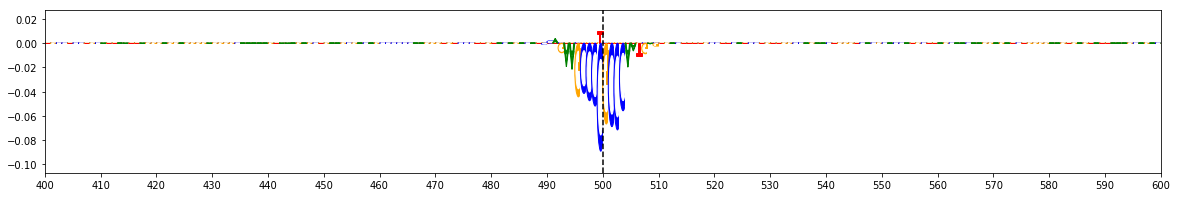


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55827552   ||    chr17 : 75088242 - 75088243   ||    Locus: 103   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  1.87E-03
Alzheimers_Lambert_2013 	  8.30E-03

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.4684   ||   Center / 200bp : 0.3916
Noneffect Sequence : CGCAAGCCCGAGGGCGCTCG


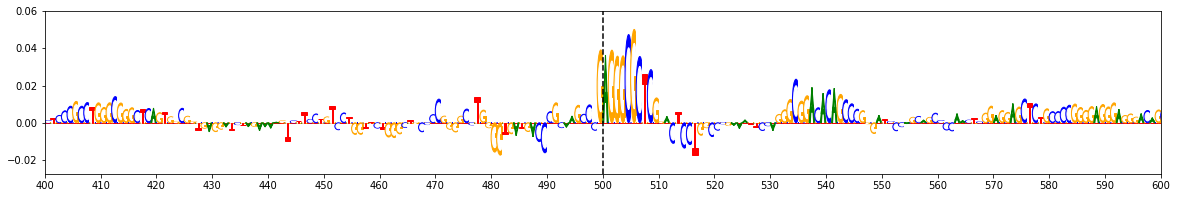

Effect Allele : A   ||   Explain Score : 0.1525   ||   Center / 200bp : 0.1729
Effect Sequence : CGCAAGCCCAAGGGCGCTCG


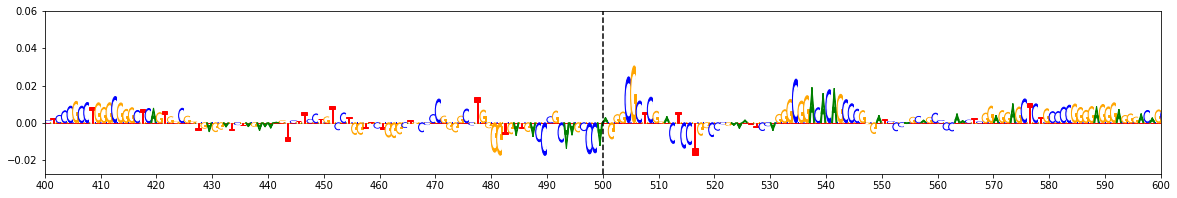

Allele Ratio : 0.3256   ||   Allele Difference : -0.4024  ||  ISM Score : -0.6376  ||  deltaSVM Score : -3.7162


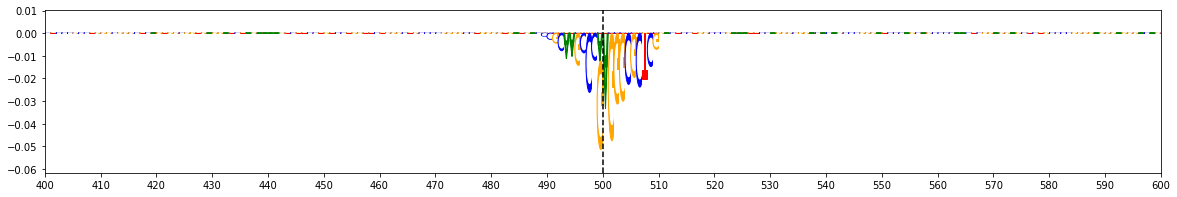


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 218   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.8536   ||   Center / 200bp : 0.5826
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


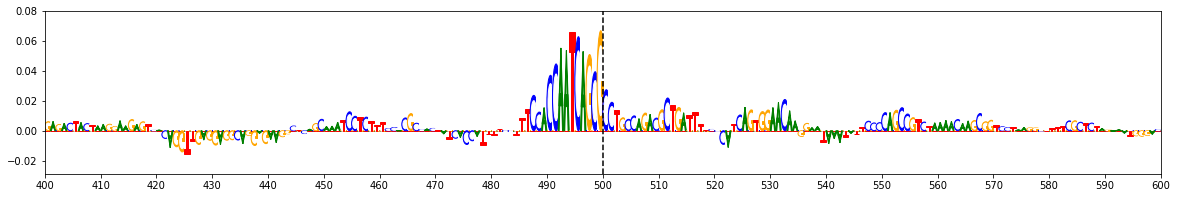

Effect Allele : NAN   ||   Explain Score : 0.4329   ||   Center / 200bp : 0.4126
Effect Sequence : CCAATCAGCCCCTGCCAGAC


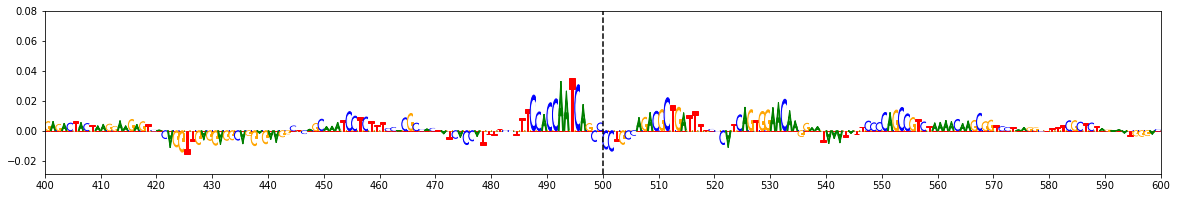

Allele Ratio : 0.5071   ||   Allele Difference : -0.4786  ||  ISM Score : -0.7287  ||  deltaSVM Score : -4.3839


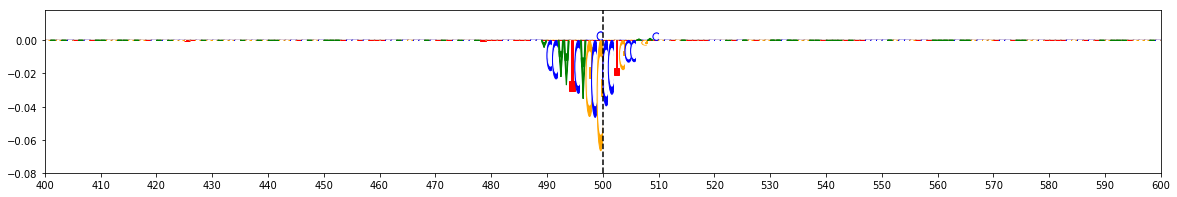


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 190   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9133   ||   Center / 200bp : 0.4095
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


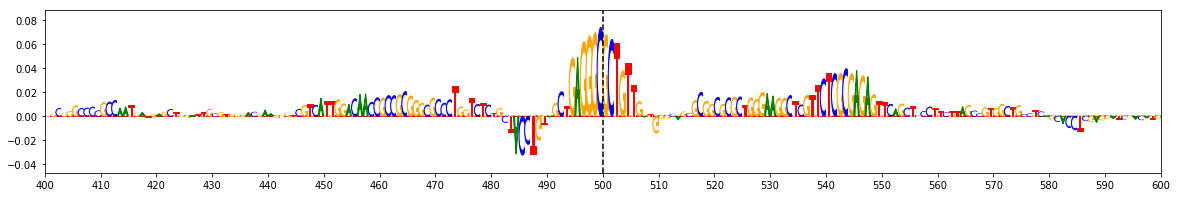

Effect Allele : T   ||   Explain Score : 0.3502   ||   Center / 200bp : 0.2099
Effect Sequence : AGCTGAGGGTGCTGTTGATG


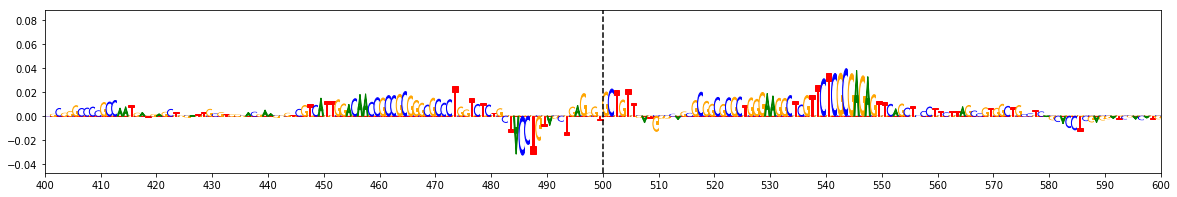

Allele Ratio : 0.3835   ||   Allele Difference : -0.6029  ||  ISM Score : -0.9494  ||  deltaSVM Score : -5.502


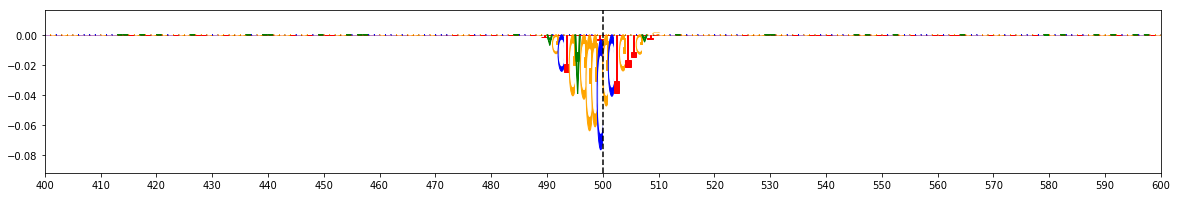


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3733345   ||    chr4 : 960458 - 960459   ||    Locus: 198   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.35E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.881   ||   Center / 200bp : 0.6008
Noneffect Sequence : GATGAGGGCGGGTCCCGCTC


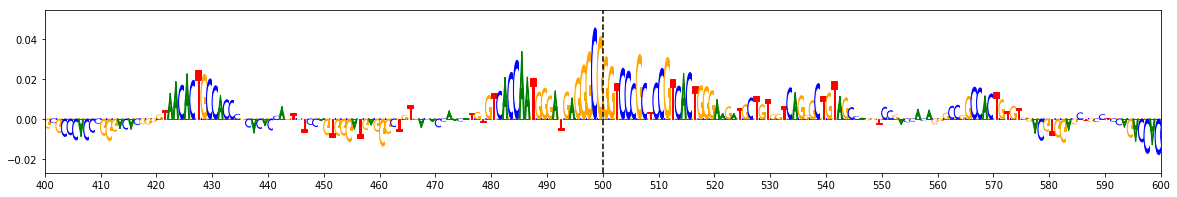

Effect Allele : T   ||   Explain Score : 0.5239   ||   Center / 200bp : 0.4748
Effect Sequence : GATGAGGGCTGGTCCCGCTC


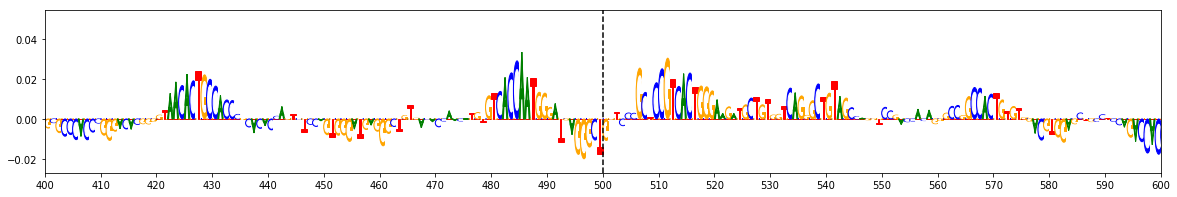

Allele Ratio : 0.5947   ||   Allele Difference : -0.4651  ||  ISM Score : -0.7344  ||  deltaSVM Score : -4.2542


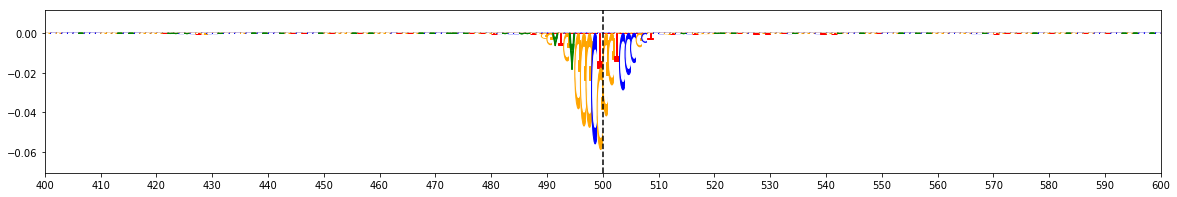


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344792   ||    chr19 : 45326123 - 45326124   ||    Locus: 164   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.52E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1691   ||   Center / 200bp : 0.3469
Noneffect Sequence : CTAGTCTCAGACTCCTACCT


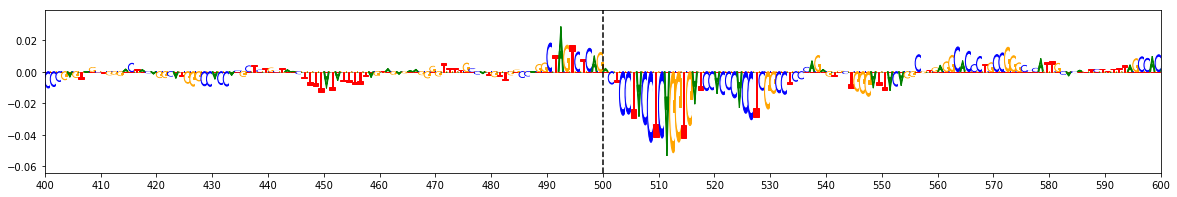

Effect Allele : A   ||   Explain Score : 0.0659   ||   Center / 200bp : 0.171
Effect Sequence : CTAGTCTCAAACTCCTACCT


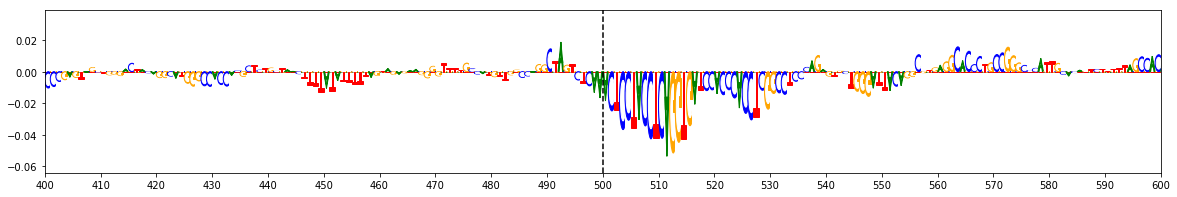

Allele Ratio : 0.3897   ||   Allele Difference : -0.2293  ||  ISM Score : -0.364  ||  deltaSVM Score : -2.0216


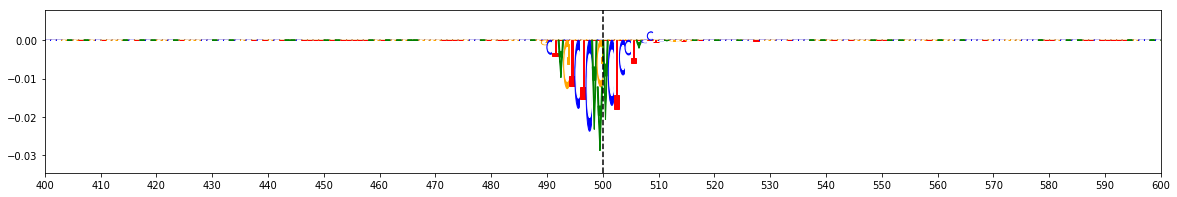


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 165   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.4907   ||   Center / 200bp : 0.5137
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


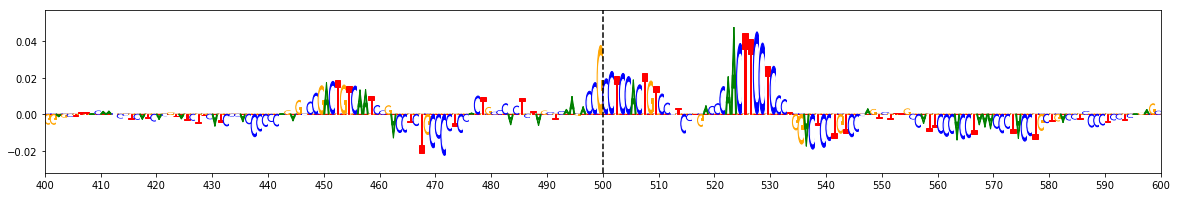

Effect Allele : C   ||   Explain Score : 0.2872   ||   Center / 200bp : 0.3847
Effect Sequence : CTCAAGACCCCCTCCACTGT


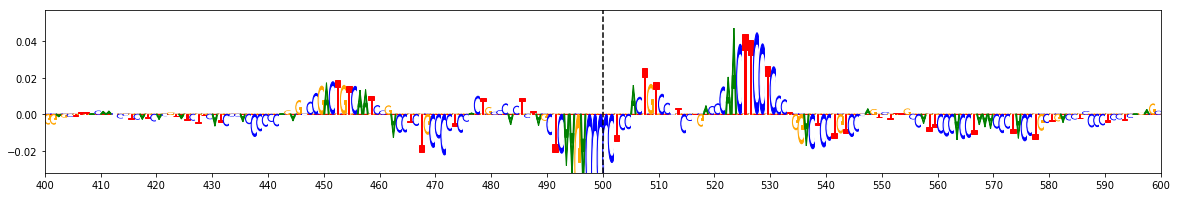

Allele Ratio : 0.5853   ||   Allele Difference : -0.6723  ||  ISM Score : -1.0666  ||  deltaSVM Score : -6.1466


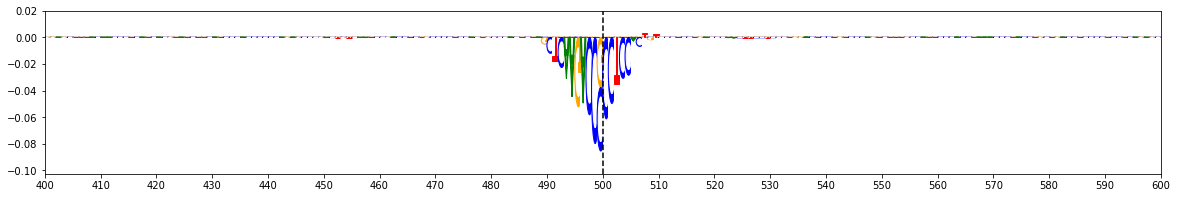


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 68   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4083   ||   Center / 200bp : 0.6749
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


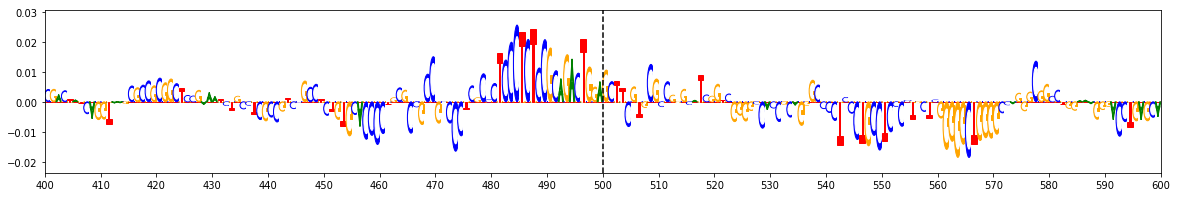

Effect Allele : G   ||   Explain Score : 0.346   ||   Center / 200bp : 0.6378
Effect Sequence : GCAGACTGGGGCTTCGTGCG


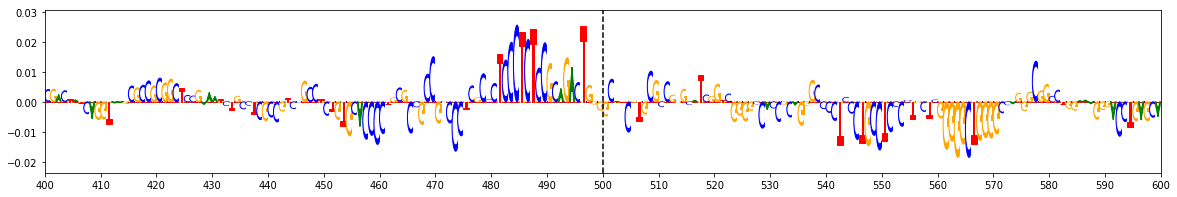

Allele Ratio : 0.8474   ||   Allele Difference : -0.0758  ||  ISM Score : -0.1218  ||  deltaSVM Score : -0.7096


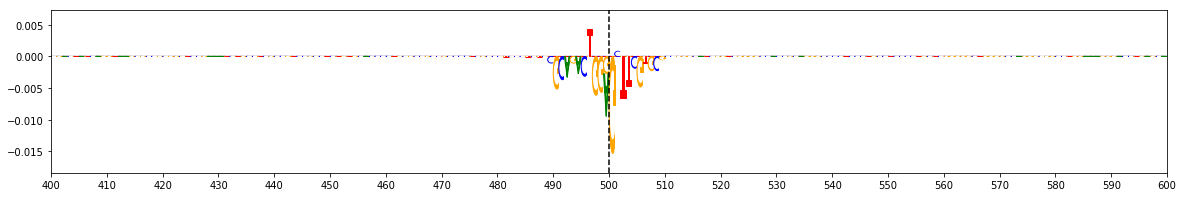


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72914885   ||    chr17 : 78426790 - 78426791   ||    Locus: 106   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  4.47E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.9576   ||   Center / 200bp : 0.4936
Noneffect Sequence : TGTTCTGGAACTGCCAGAGC


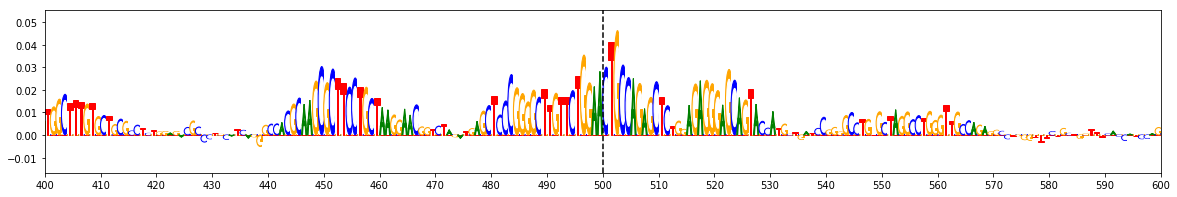

Effect Allele : C   ||   Explain Score : 0.5973   ||   Center / 200bp : 0.3781
Effect Sequence : TGTTCTGGACCTGCCAGAGC


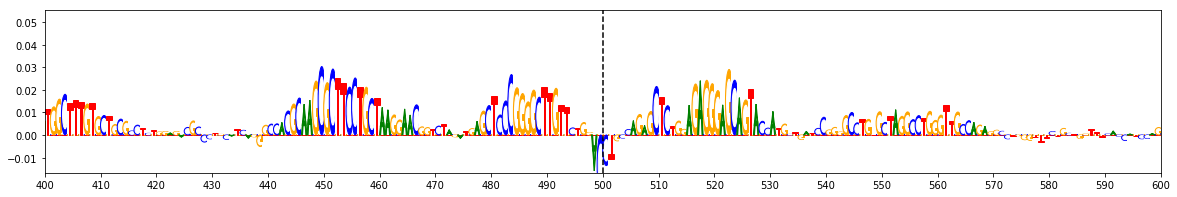

Allele Ratio : 0.6238   ||   Allele Difference : -0.4309  ||  ISM Score : -0.6667  ||  deltaSVM Score : -3.9142


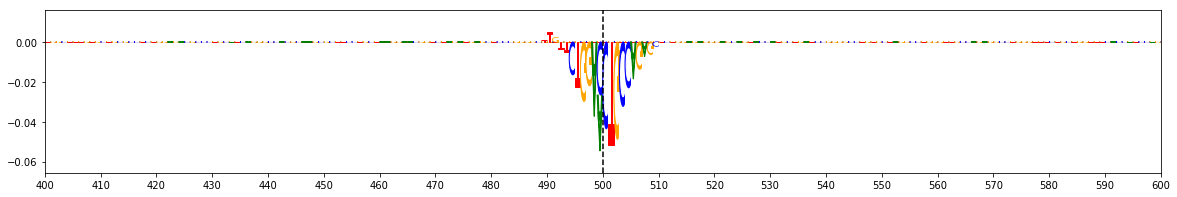


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs405509   ||    chr19 : 44905578 - 44905579   ||    Locus: 137   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.58E-144
Alzheimers_Kunkle_2019 		  3.11E-114
Alzheimers_Lambert_2013 	  4.35E-73

Coloc:  True

Noneffect Allele : T   ||   Explain Score : 0.2222   ||   Center / 200bp : 0.368
Noneffect Sequence : GGGTGTCTGTATTACTGGGC


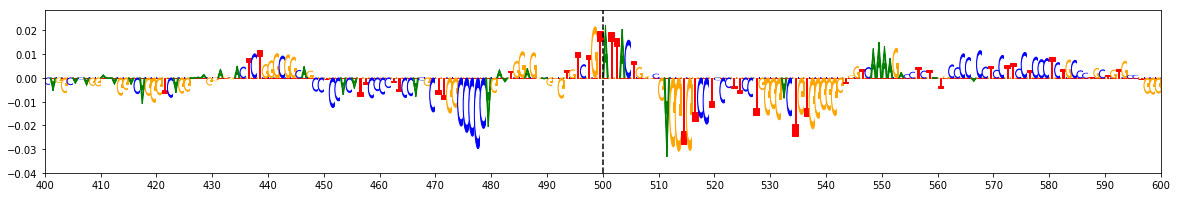

Effect Allele : G   ||   Explain Score : 0.1038   ||   Center / 200bp : 0.2141
Effect Sequence : GGGTGTCTGGATTACTGGGC


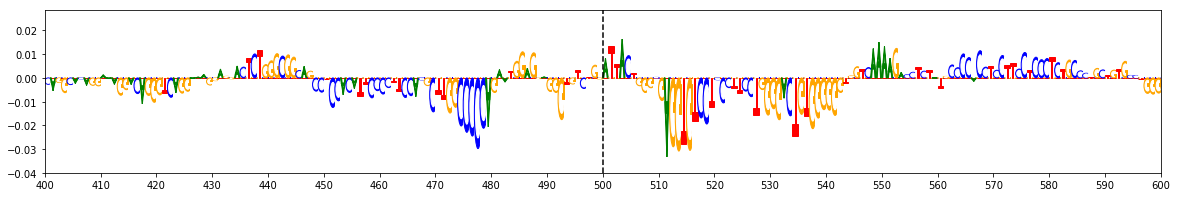

Allele Ratio : 0.4671   ||   Allele Difference : -0.1586  ||  ISM Score : -0.254  ||  deltaSVM Score : -1.4802


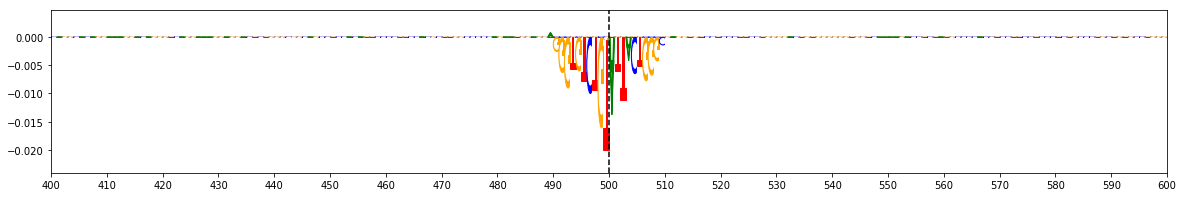


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062785   ||    chr17 : 45947195 - 45947196   ||    Locus: 79   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.33E-22

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.7545   ||   Center / 200bp : 0.5569
Noneffect Sequence : CTCCCAGTGGCTGCCTGTGT


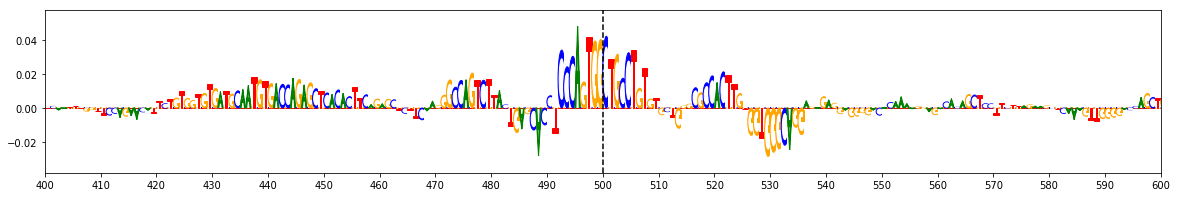

Effect Allele : T   ||   Explain Score : 0.5392   ||   Center / 200bp : 0.4732
Effect Sequence : CTCCCAGTGTCTGCCTGTGT


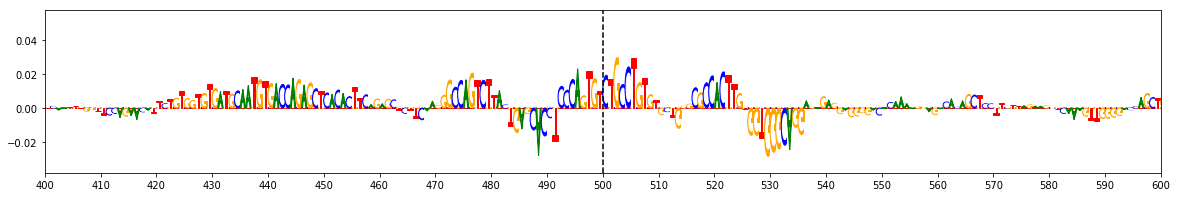

Allele Ratio : 0.7147   ||   Allele Difference : -0.2325  ||  ISM Score : -0.3639  ||  deltaSVM Score : -2.1358


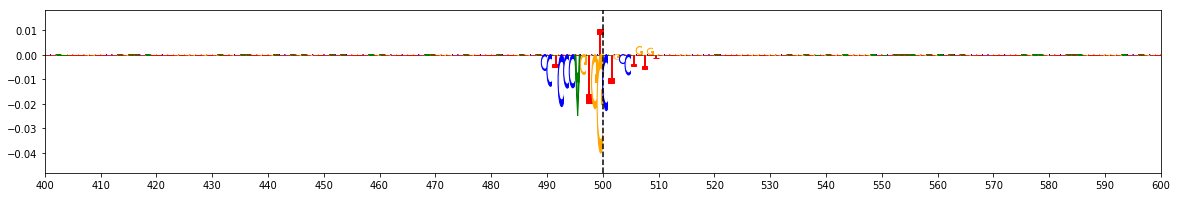


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 220   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.417   ||   Center / 200bp : 0.3882
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


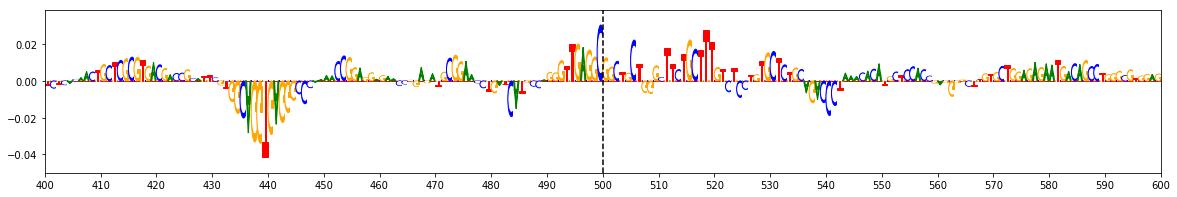

Effect Allele : T   ||   Explain Score : 0.2087   ||   Center / 200bp : 0.2412
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


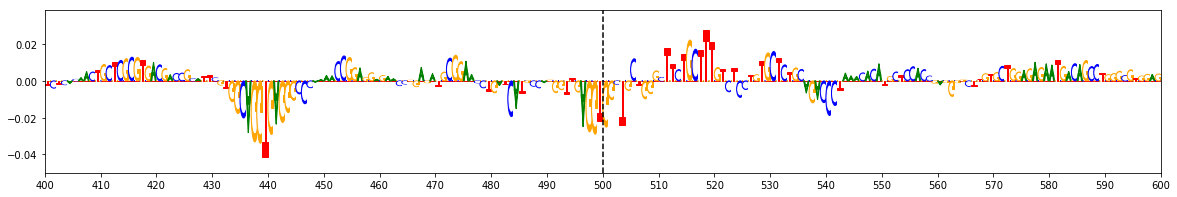

Allele Ratio : 0.5005   ||   Allele Difference : -0.4099  ||  ISM Score : -0.6409  ||  deltaSVM Score : -3.6863


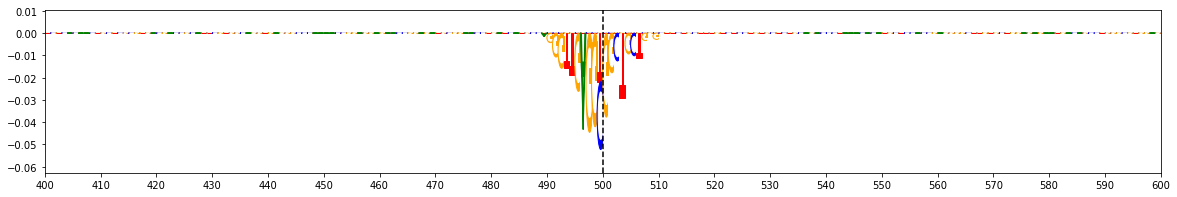


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62064662   ||    chr17 : 46002354 - 46002355   ||    Locus: 85   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.18E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.3214   ||   Center / 200bp : 0.4854
Noneffect Sequence : TAGAGGAGAACTGAAGAAGC


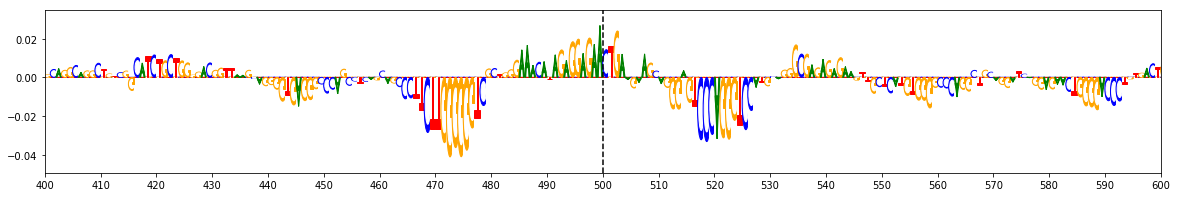

Effect Allele : G   ||   Explain Score : 0.2022   ||   Center / 200bp : 0.3725
Effect Sequence : TAGAGGAGAGCTGAAGAAGC


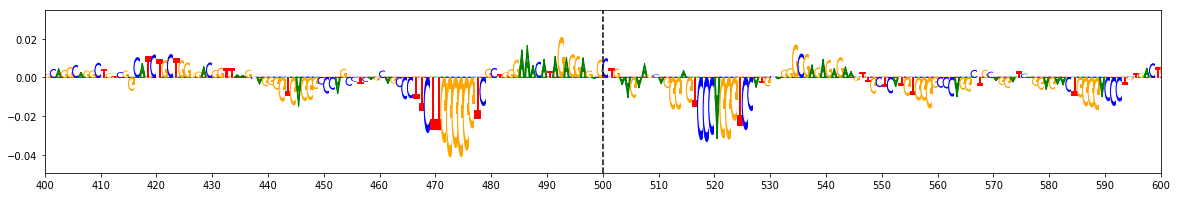

Allele Ratio : 0.6291   ||   Allele Difference : -0.1397  ||  ISM Score : -0.2208  ||  deltaSVM Score : -1.2439


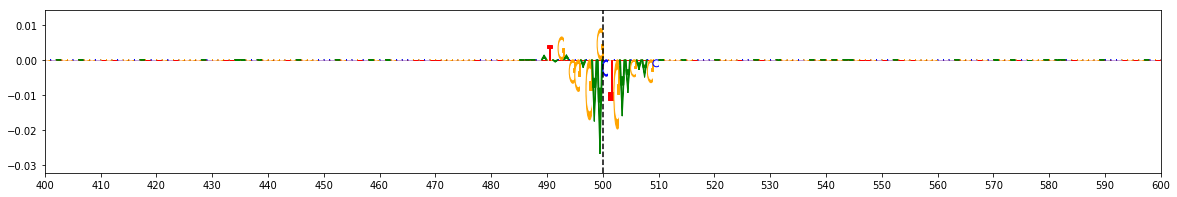


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs75511804   ||    chr17 : 5235008 - 5235009   ||    Locus: 54   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.68E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.3634   ||   Center / 200bp : 0.5128
Noneffect Sequence : TGTCGCTCCCGCAAGGCCTA


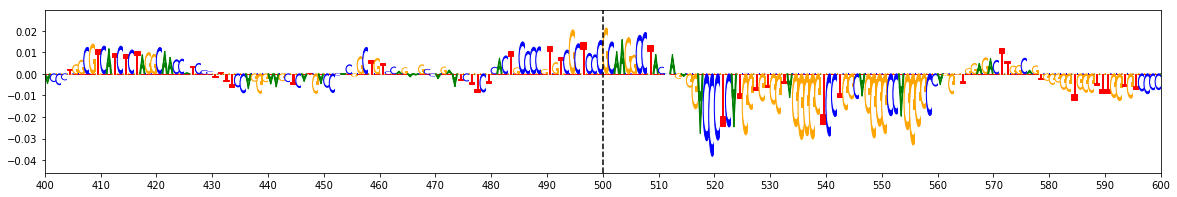

Effect Allele : T   ||   Explain Score : 0.246   ||   Center / 200bp : 0.4167
Effect Sequence : TGTCGCTCCTGCAAGGCCTA


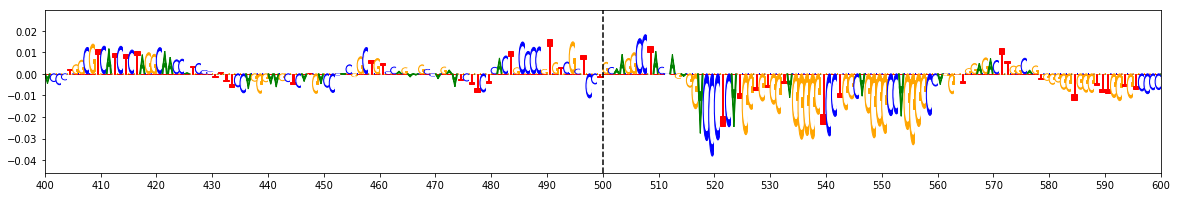

Allele Ratio : 0.6769   ||   Allele Difference : -0.1339  ||  ISM Score : -0.2122  ||  deltaSVM Score : -1.2052


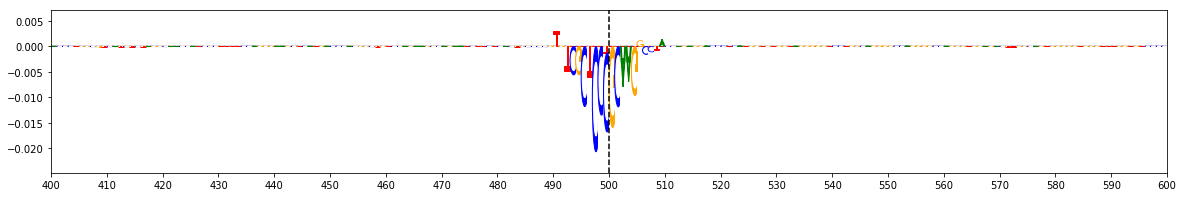


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76516995   ||    chr2 : 127107344 - 127107345   ||    Locus: 169   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  NAN
Alzheimers_Kunkle_2019 		  4.83E-10

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 1.51   ||   Center / 200bp : 0.7207
Noneffect Sequence : GCACCGCCCGGGGGCGGGGA


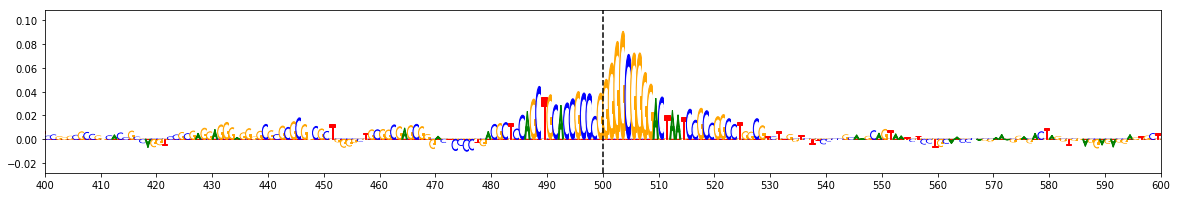

Effect Allele : C   ||   Explain Score : 1.4785   ||   Center / 200bp : 0.7217
Effect Sequence : GCACCGCCCCGGGGCGGGGA


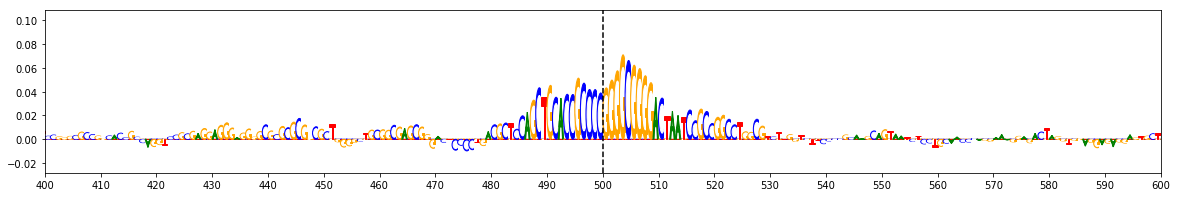

Allele Ratio : 0.9791   ||   Allele Difference : -0.0309  ||  ISM Score : -0.1467  ||  deltaSVM Score : 0.1227


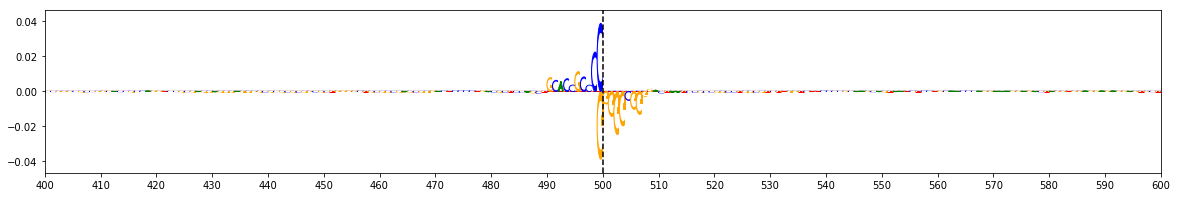


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs544458   ||    chr11 : 86067881 - 86067882   ||    Locus: 16   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.70E-11

Coloc:  False

Noneffect Allele : T   ||   Explain Score : 0.689   ||   Center / 200bp : 0.5611
Noneffect Sequence : ACAACACAATGATTAAATTC


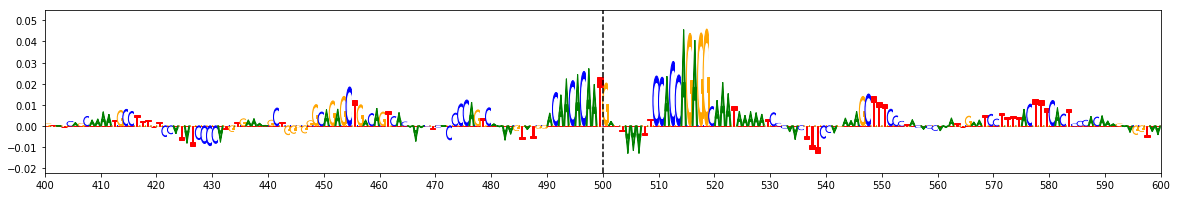

Effect Allele : C   ||   Explain Score : 0.5306   ||   Center / 200bp : 0.496
Effect Sequence : ACAACACAACGATTAAATTC


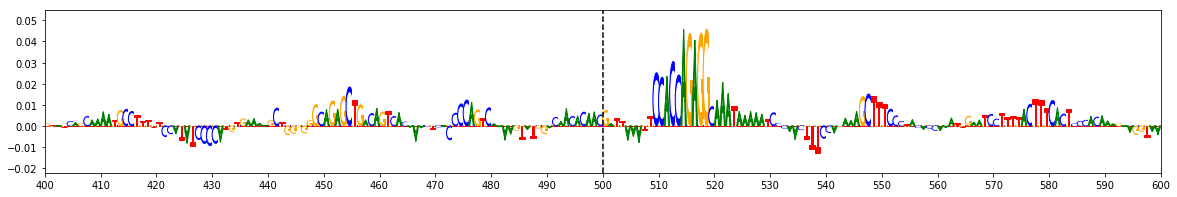

Allele Ratio : 0.7702   ||   Allele Difference : -0.1395  ||  ISM Score : -0.2184  ||  deltaSVM Score : -1.2972


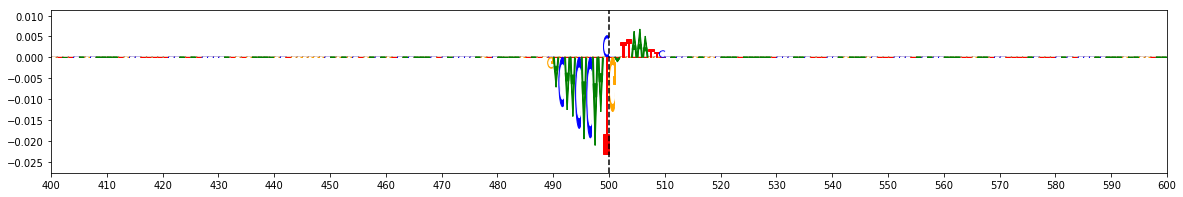


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062770   ||    chr17 : 45942313 - 45942314   ||    Locus: 77   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.67E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.4484   ||   Center / 200bp : 0.5322
Noneffect Sequence : CGTTTCTTCCTCCTTACAAA


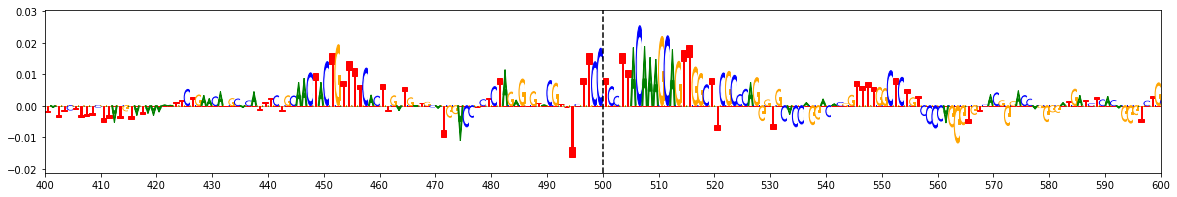

Effect Allele : T   ||   Explain Score : 0.3276   ||   Center / 200bp : 0.4539
Effect Sequence : CGTTTCTTCTTCCTTACAAA


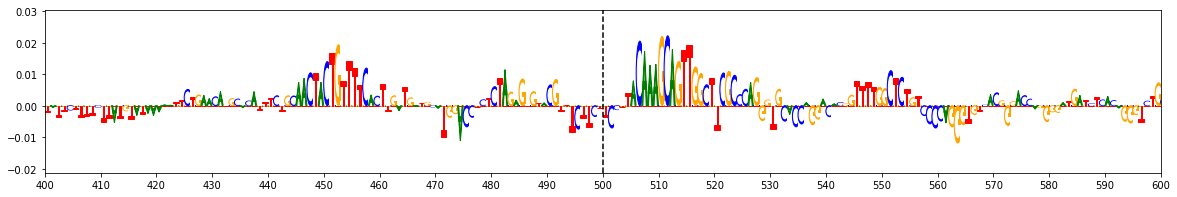

Allele Ratio : 0.7307   ||   Allele Difference : -0.1486  ||  ISM Score : -0.2315  ||  deltaSVM Score : -1.3122


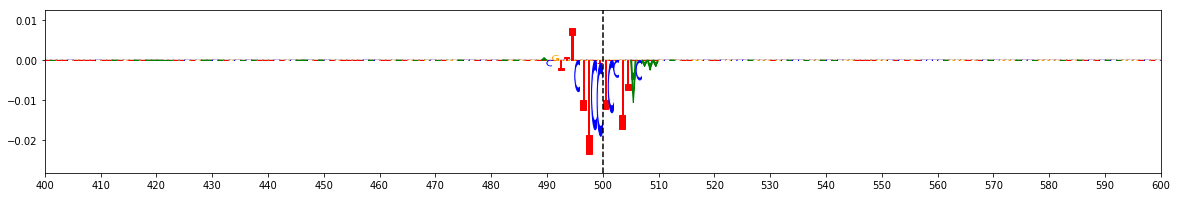


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55682376   ||    chr17 : 45914521 - 45914522   ||    Locus: 70   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.96E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.044   ||   Center / 200bp : 0.5985
Noneffect Sequence : ACAAGGCAGATACTGTGTAC


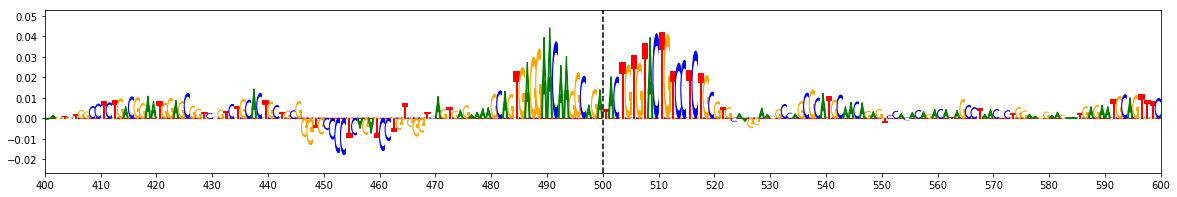

Effect Allele : G   ||   Explain Score : 0.8747   ||   Center / 200bp : 0.5547
Effect Sequence : ACAAGGCAGGTACTGTGTAC


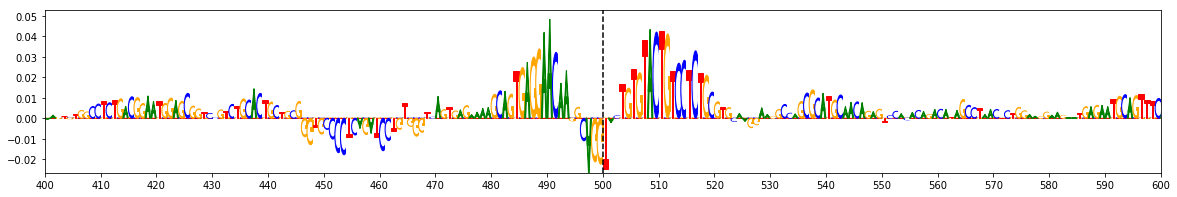

Allele Ratio : 0.8378   ||   Allele Difference : -0.282  ||  ISM Score : -0.4454  ||  deltaSVM Score : -2.5333


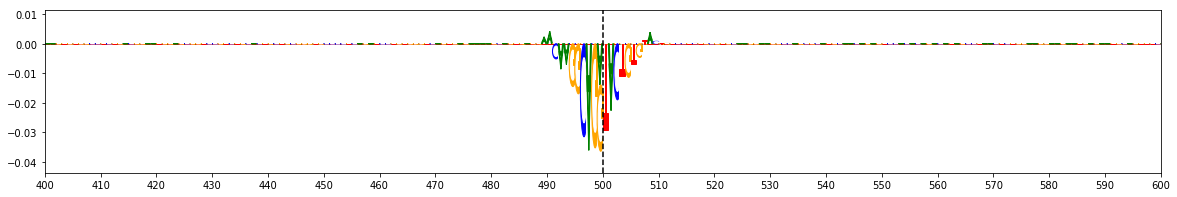


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12445650   ||    chr16 : 31033575 - 31033576   ||    Locus: 43   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.54E-04

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.28   ||   Center / 200bp : 0.5713
Noneffect Sequence : GCGGGAGCTAGAGCGGGGAA


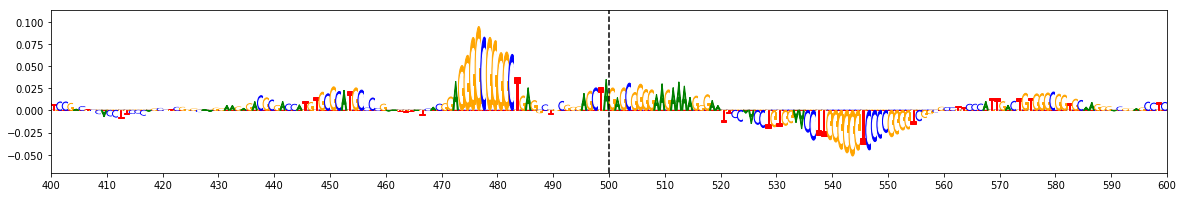

Effect Allele : G   ||   Explain Score : 1.0407   ||   Center / 200bp : 0.5205
Effect Sequence : GCGGGAGCTGGAGCGGGGAA


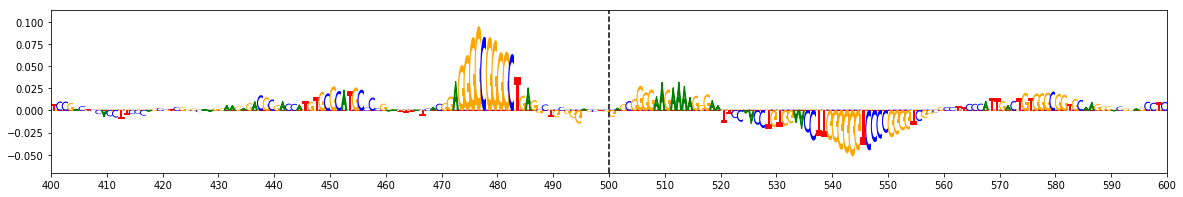

Allele Ratio : 0.8131   ||   Allele Difference : -0.2851  ||  ISM Score : -0.4457  ||  deltaSVM Score : -2.5574


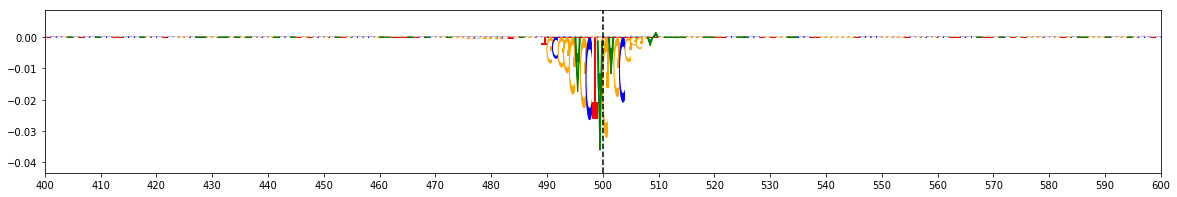


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1237999   ||    chr11 : 86103987 - 86103988   ||    Locus: 20   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.14E-16
Alzheimers_Kunkle_2019 		  1.46E-13
Alzheimers_Lambert_2013 	  4.68E-13

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.7115   ||   Center / 200bp : 0.3667
Noneffect Sequence : ATTATCTATGAGTCACCAAC


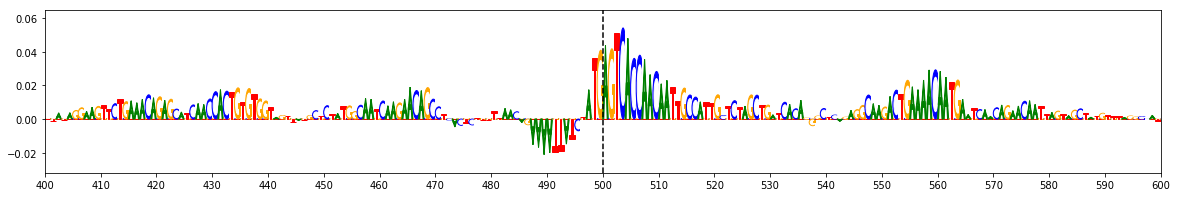

Effect Allele : A   ||   Explain Score : 0.3751   ||   Center / 200bp : 0.2339
Effect Sequence : ATTATCTATAAGTCACCAAC


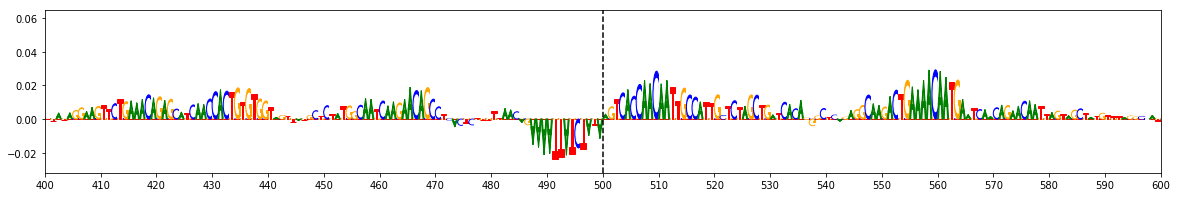

Allele Ratio : 0.5271   ||   Allele Difference : -0.4128  ||  ISM Score : -0.6433  ||  deltaSVM Score : -3.6864


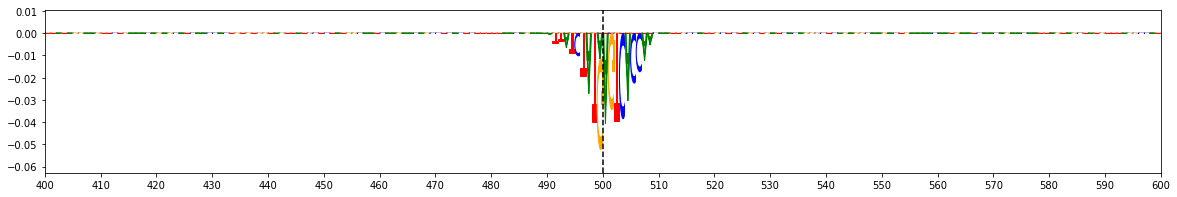


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
217   chr4   89829957   89829958    rs2583980      T         G   T      G   
183   chr2  134713164  134713165    rs2276161      T         A   A      T   
31   chr14   54882150   54882151   rs11158026      T         C   C  A,G,T   
184   chr2  134718389  134718390   rs62171393      G         C   C      G   
172   chr2  127107345  127107346   rs78710909    NAN       NAN   G      C   
39   chr15   82182913   82182914   rs72749557      A         C   C      A   
88   chr17   46004160   46004161   rs62064665      T         C   T      C   
24   chr11  121590239  121590240   rs77819448      G         A   A      G   
55   chr17    5282069    5282070  rs113151753      G         C   C    G,T   
105  chr17   78426733   78426734   rs72914883      G         A   A      G   
141  chr19   44912841   44912842   rs72654437      A         G   G      A   
19   chr11   86069405   86069406    rs3016327      T         C   T      C   
228   chr7   23106569   23106570    rs2072369      A         G   A    C,G   
205   chr4     987143     987144   rs10902762      G         A   G      A   
166  chr19   51224705   51224706    rs3865444      A         C   C      A   
5    chr10  102245652  102245653    rs2296887      T         C   T      C   
180   chr2  127135233  127135234    rs6733839      T         C   C      T   
13   chr11   60333145   60333146   rs10792265      G         A   A      G   
193   chr3   52368659   52368660  rs145480601      G         A   G      A   
186  chr20    6006303    6006304    rs6085343      G         A   G      A   
78   chr17   45947185   45947186   rs62062784      G         C   C      G   
225   chr7   23105294   23105295   rs10241208      C         G   G      C   
49   chr16   50709419   50709420   rs11647841      G         A   G      A   
206   chr4   18022407   18022408    rs1380295      G         C   C    A,G   
120  chr19   44808778   44808779    rs2967671      G         C   C      G   
185   chr2  168247488  168247489   rs76179989      T         G   T      G   
222   chr5  103224668  103224669     rs246913      G         C   G      C   
199   chr4     960486     960487    rs3733346      T         C   T      C   
46   chr16   31106091   31106092    rs2032915      T         C   C      T   
176   chr2  127128656  127128657   rs13025765      T         C   C      T   
..     ...        ...        ...          ...    ...       ...  ..    ...   
157  chr19   45040496   45040497   rs76856627      G         A   A      G   
53   chr17    5166379    5166380   rs34716007      A         G   G    A,T   
117  chr19   18428933   18428934   rs34746918      T         C   C      T   
11   chr11   60310702   60310703    rs7103808      G         A   A      G   
84   chr17   46002200   46002201   rs17573447      T         C   C      T   
188   chr3   48685868   48685869    rs6792510      G         C   G      C   
50   chr17    4872837    4872838   rs72835040      A         G   G    A,C   
113  chr17   78432578   78432579   rs72907463      G         A   G      A   
231   chr7  100198522  100198523    rs3735241      C         A   A    C,T   
8    chr11   47408352   47408353    rs7947450      A         G   G      A   
94   chr17   46193442   46193443  rs113417378      G         A   A      G   
42   chr16   31033361   31033362   rs58726213      G         A   A      G   
45   chr16   31106067   31106068   rs56314408      T         C   T      C   
200   chr4     960522     960523    rs3733349      T         C   C      T   
99   chr17   75034714   75034715   rs11870474      A         C   C    A,T   
152  chr19   44955205   44955206    rs8102895      A         G   A      G   
236   chr9   33929207   33929208   rs10120819      T         C   T      C   
202   chr4     973656     973657   rs13137144      G         A   G    A,C   
234   chr8   22604860   22604861    rs3735901      T         C   T      C   
145  chr19   44913220   44913221     rs584007      A         G   A      G   
0  

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs2583980   ||    chr4 : 89829957 - 89829958   ||    Locus: 217   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  1.95E-07
23andme_PD_hg38 		  9.87E-09

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3636   ||  Center / 200bp: 0.3165
Effect Sequence: TGTTGTTAGTGGCTGGTGTT


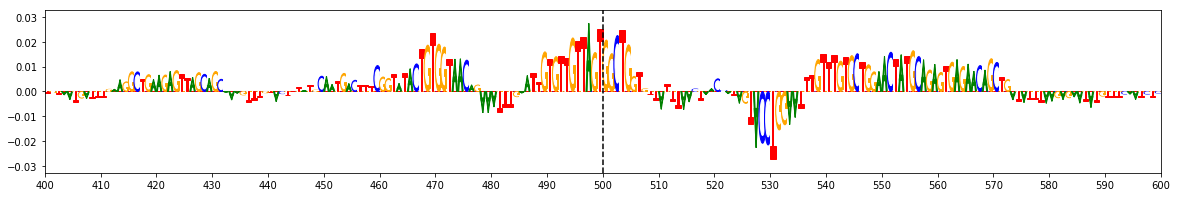

Noneffect Allele: G   ||  Explain Score: 0.1024   ||  Center / 200bp: 0.1153
Noneffect Sequence: TGTTGTTAGGGGCTGGTGTT


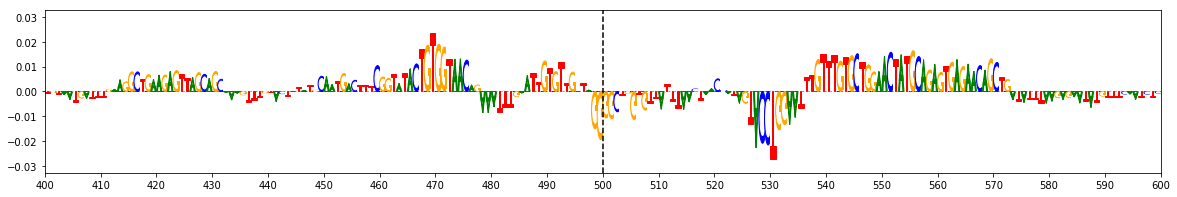

Allele Ratio : 3.5516   ||   Allele Difference : 0.3496  ||  ISM Score : 0.5463  ||  deltaSVM Score : 3.1447


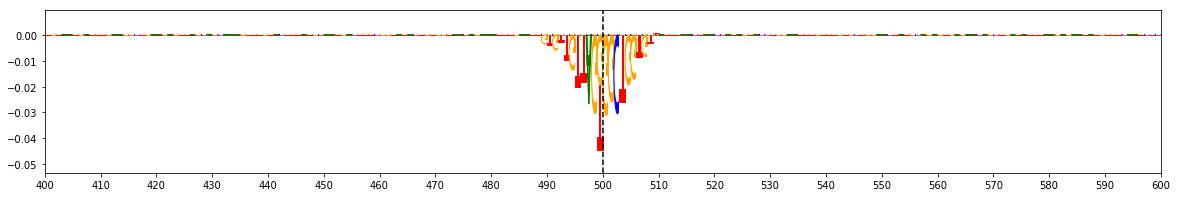


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2276161   ||    chr2 : 134713164 - 134713165   ||    Locus: 183   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  9.40E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.6823   ||  Center / 200bp: 0.5999
Effect Sequence: GGCAACAGCTGCACATATTG


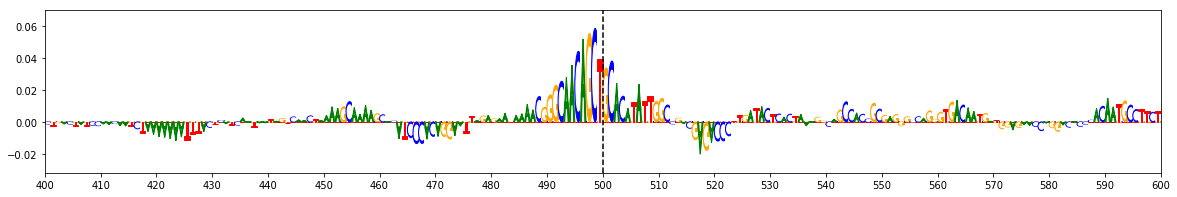

Noneffect Allele: A   ||  Explain Score: 0.4887   ||  Center / 200bp: 0.5182
Noneffect Sequence: GGCAACAGCAGCACATATTG


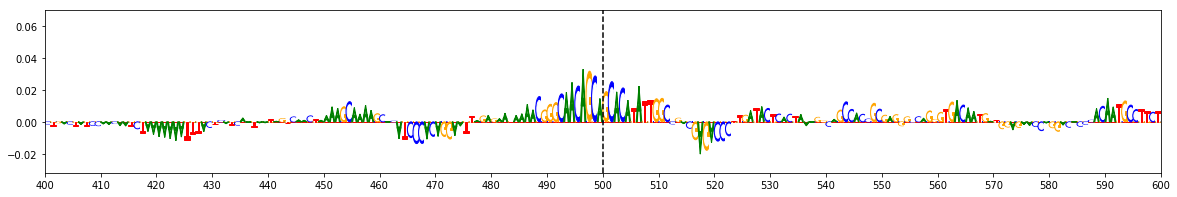

Allele Ratio : 1.396   ||   Allele Difference : 0.1934  ||  ISM Score : 0.3001  ||  deltaSVM Score : 1.7537


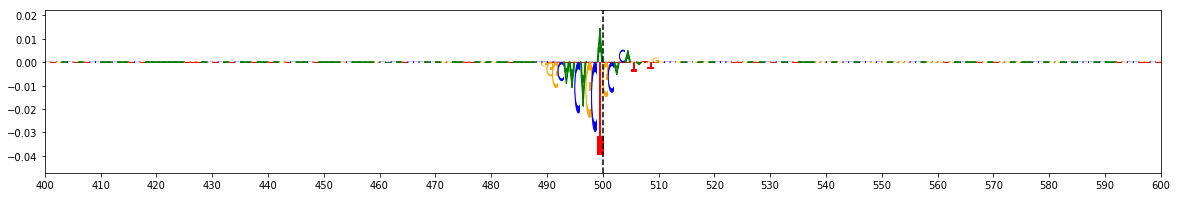


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11158026   ||    chr14 : 54882150 - 54882151   ||    Locus: 31   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.65E-07
Nalls_23andMe 		  2.65E-07

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7703   ||  Center / 200bp: 0.6343
Effect Sequence: GGAACCGCATGCACAGTGGT


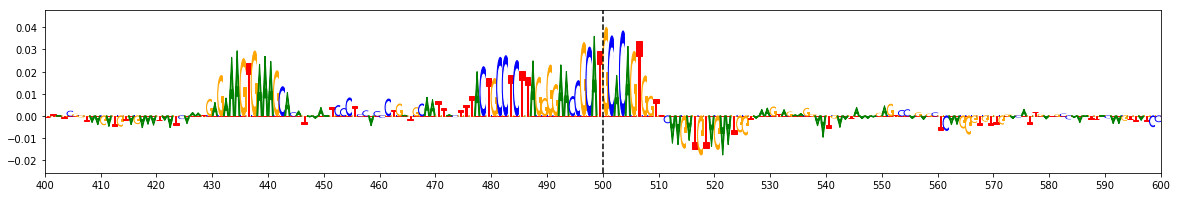

Noneffect Allele: C   ||  Explain Score: 0.5891   ||  Center / 200bp: 0.5701
Noneffect Sequence: GGAACCGCACGCACAGTGGT


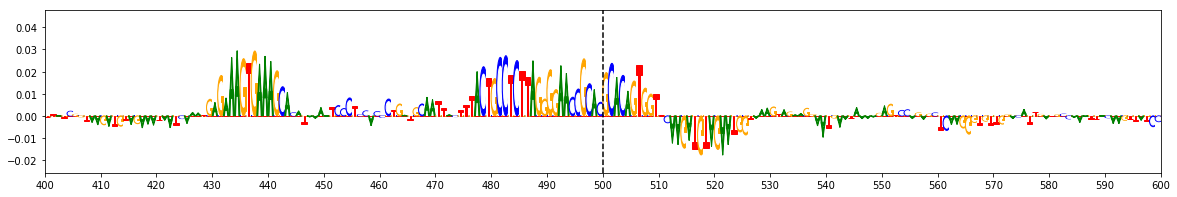

Allele Ratio : 1.3074   ||   Allele Difference : 0.1812  ||  ISM Score : 0.2837  ||  deltaSVM Score : 1.6072


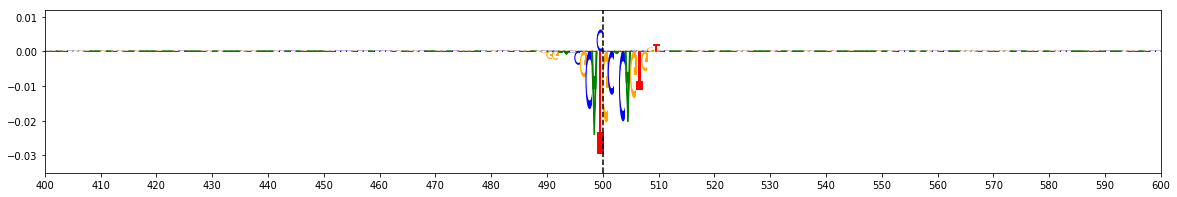


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171393   ||    chr2 : 134718389 - 134718390   ||    Locus: 184   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  9.02E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6876   ||  Center / 200bp: 0.5192
Effect Sequence: CGGAGTGGCGCAGAAGCGCT


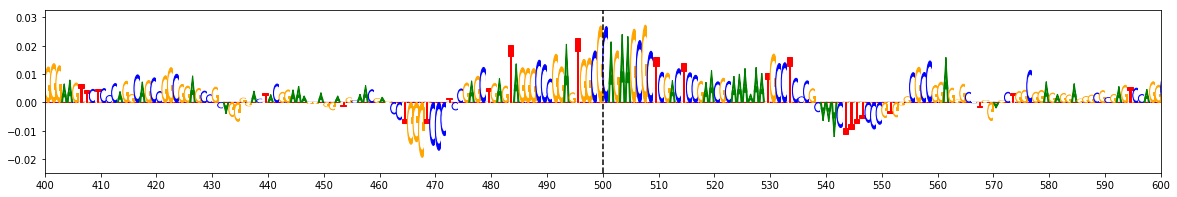

Noneffect Allele: C   ||  Explain Score: 0.4328   ||  Center / 200bp: 0.4046
Noneffect Sequence: CGGAGTGGCCCAGAAGCGCT


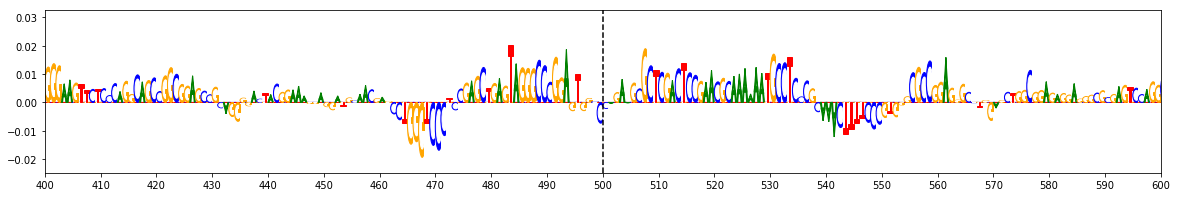

Allele Ratio : 1.5886   ||   Allele Difference : 0.2704  ||  ISM Score : 0.4238  ||  deltaSVM Score : 2.4385


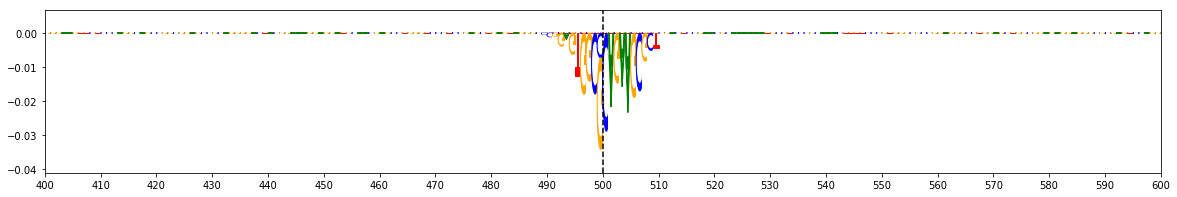


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78710909   ||    chr2 : 127107345 - 127107346   ||    Locus: 172   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  4.44E-07
Alzheimers_Lambert_2013 	  NAN

Coloc:  False

Effect Allele: NAN   ||  Explain Score: 1.5085   ||  Center / 200bp: 0.7228
Effect Sequence: CACCGCCCCCGGGCGGGGAC


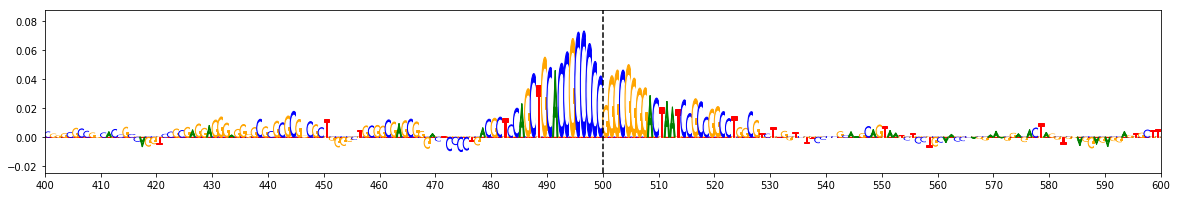

Noneffect Allele: NAN   ||  Explain Score: 1.489   ||  Center / 200bp: 0.7255
Noneffect Sequence: CACCGCCCCGGGGCGGGGAC


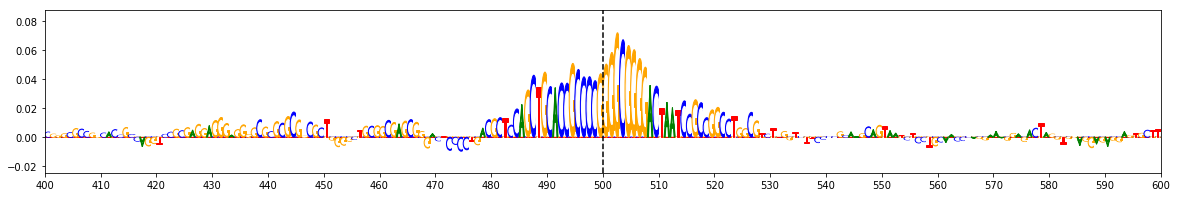

Allele Ratio : 1.013   ||   Allele Difference : 0.019  ||  ISM Score : 0.1165  ||  deltaSVM Score : -0.16


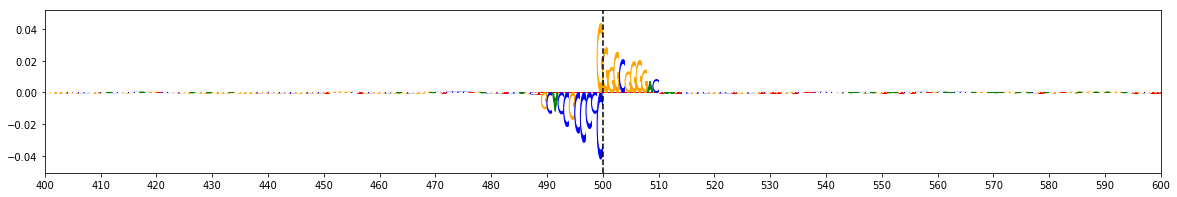


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72749557   ||    chr15 : 82182913 - 82182914   ||    Locus: 39   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  8.42E-05
Alzheimers_Lambert_2013 	  6.18E-06

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.8627   ||  Center / 200bp: 0.7189
Effect Sequence: TGAAGGCACAAGCGTACGAA


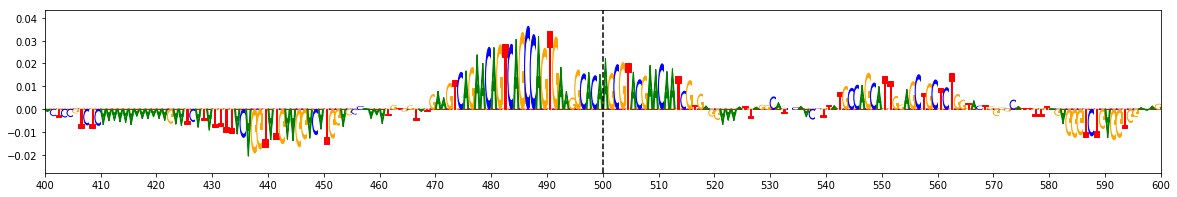

Noneffect Allele: C   ||  Explain Score: 0.8529   ||  Center / 200bp: 0.7164
Noneffect Sequence: TGAAGGCACCAGCGTACGAA


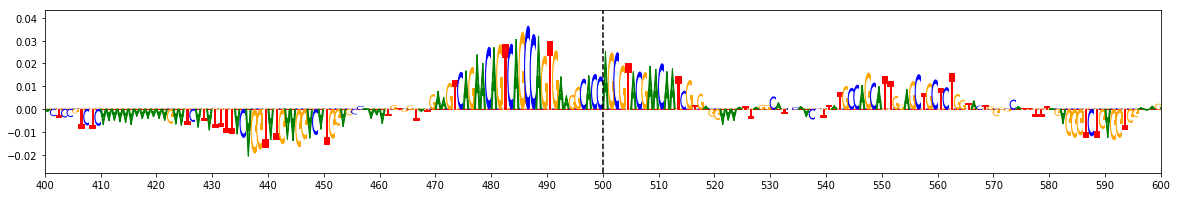

Allele Ratio : 1.0114   ||   Allele Difference : 0.0098  ||  ISM Score : 0.0155  ||  deltaSVM Score : 0.1062


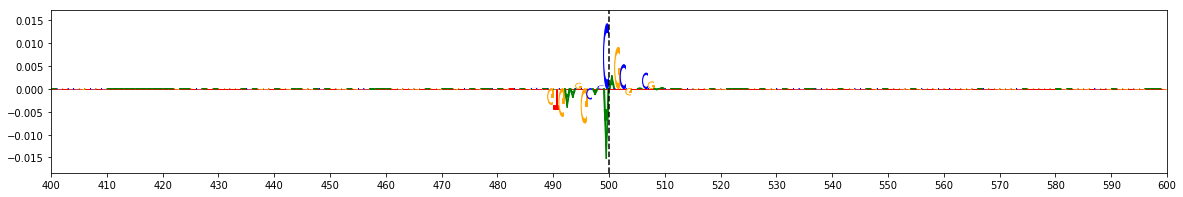


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62064665   ||    chr17 : 46004160 - 46004161   ||    Locus: 88   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.11E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.2718   ||  Center / 200bp: 0.6187
Effect Sequence: CAGGCCAAGTCTGGGCCAGC


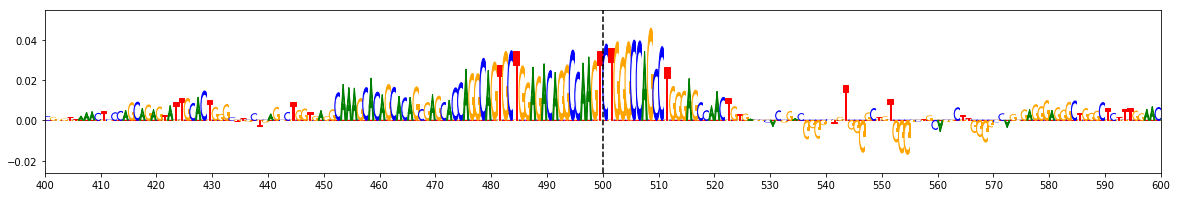

Noneffect Allele: C   ||  Explain Score: 1.0835   ||  Center / 200bp: 0.5813
Noneffect Sequence: CAGGCCAAGCCTGGGCCAGC


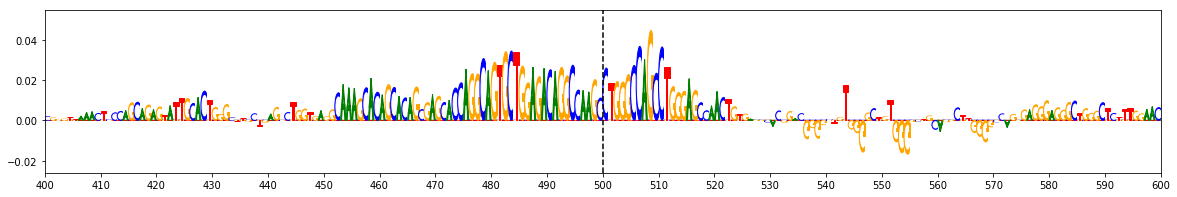

Allele Ratio : 1.1738   ||   Allele Difference : 0.1883  ||  ISM Score : 0.3035  ||  deltaSVM Score : 1.6713


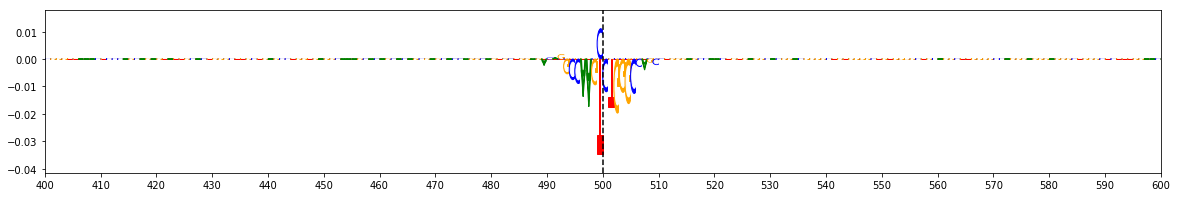


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs77819448   ||    chr11 : 121590239 - 121590240   ||    Locus: 24   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  5.46E-08

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5512   ||  Center / 200bp: 0.5621
Effect Sequence: CCACCAGCTGTGCAGGATGT


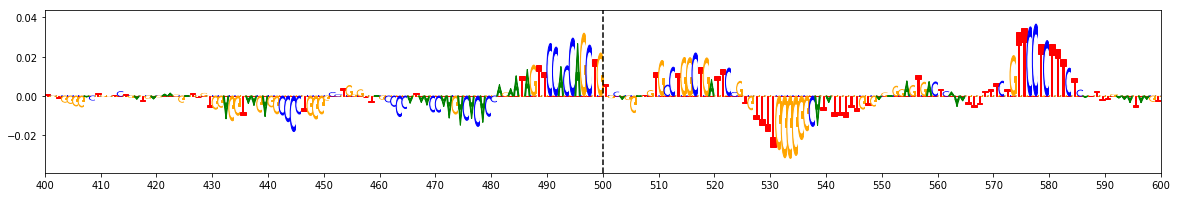

Noneffect Allele: A   ||  Explain Score: 0.4445   ||  Center / 200bp: 0.5087
Noneffect Sequence: CCACCAGCTATGCAGGATGT


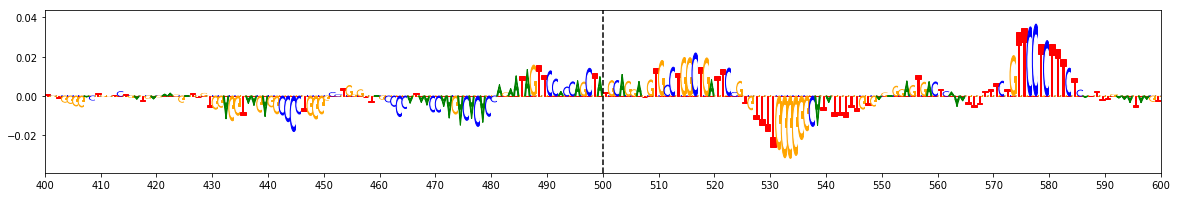

Allele Ratio : 1.2399   ||   Allele Difference : 0.0941  ||  ISM Score : 0.1474  ||  deltaSVM Score : 0.892


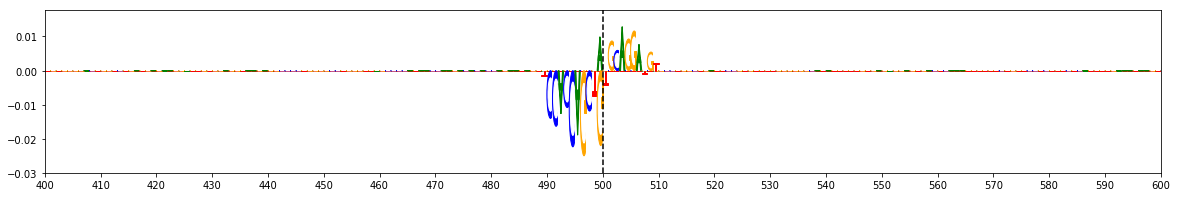


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs113151753   ||    chr17 : 5282069 - 5282070   ||    Locus: 55   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  2.04E-08

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7159   ||  Center / 200bp: 0.4852
Effect Sequence: TCAGGCGCCGAGCTCCGCCG


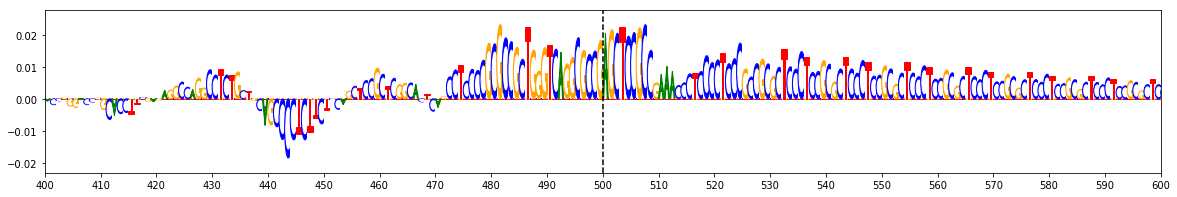

Noneffect Allele: C   ||  Explain Score: 0.4998   ||  Center / 200bp: 0.3967
Noneffect Sequence: TCAGGCGCCCAGCTCCGCCG


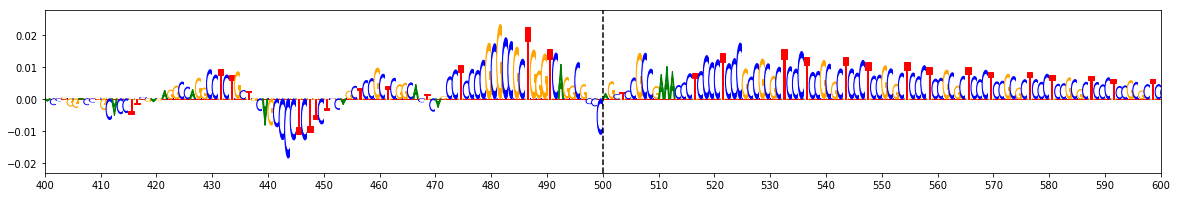

Allele Ratio : 1.4322   ||   Allele Difference : 0.2309  ||  ISM Score : 0.5735  ||  deltaSVM Score : 3.2957


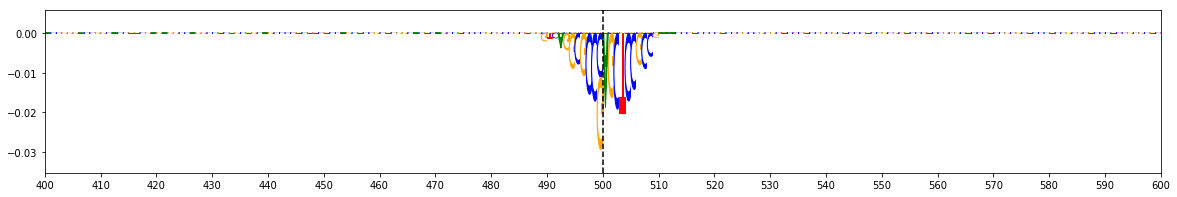


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72914883   ||    chr17 : 78426733 - 78426734   ||    Locus: 105   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  4.46E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.2206   ||  Center / 200bp: 0.4562
Effect Sequence: ATCAGGGCCGCGCAAGCGCT


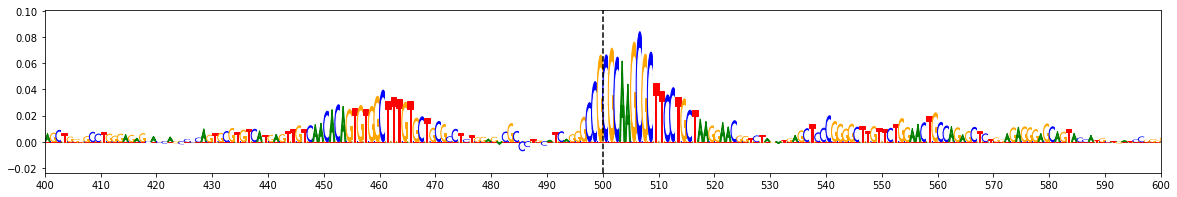

Noneffect Allele: A   ||  Explain Score: 0.8089   ||  Center / 200bp: 0.3573
Noneffect Sequence: ATCAGGGCCACGCAAGCGCT


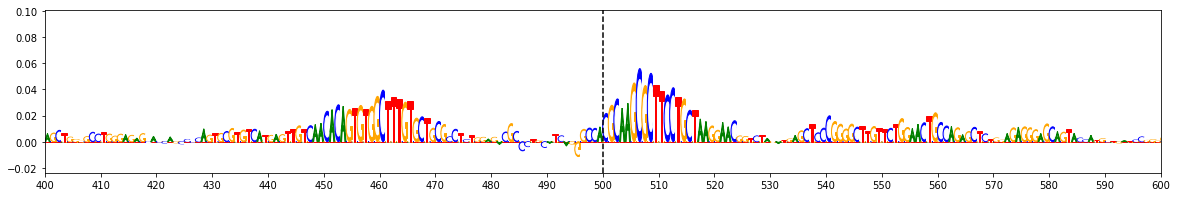

Allele Ratio : 1.509   ||   Allele Difference : 0.4312  ||  ISM Score : 0.677  ||  deltaSVM Score : 3.917


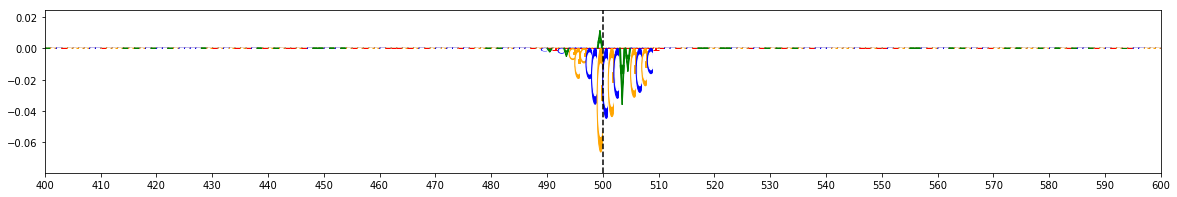


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72654437   ||    chr19 : 44912841 - 44912842   ||    Locus: 141   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.28E-09

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.6344   ||  Center / 200bp: 0.6268
Effect Sequence: ATTCTTGTGAGGTCTGGGAA


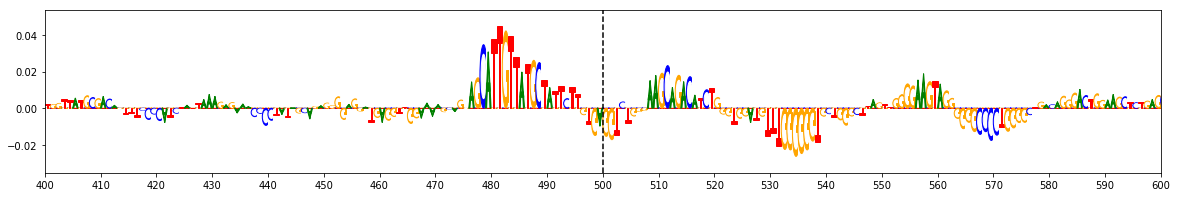

Noneffect Allele: G   ||  Explain Score: 0.6006   ||  Center / 200bp: 0.6139
Noneffect Sequence: ATTCTTGTGGGGTCTGGGAA


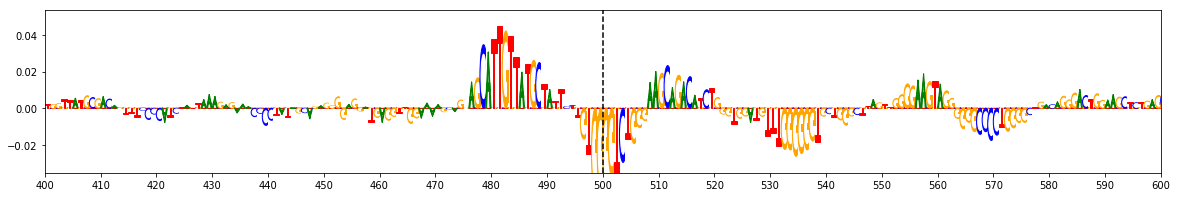

Allele Ratio : 1.0563   ||   Allele Difference : 0.2768  ||  ISM Score : 0.4324  ||  deltaSVM Score : 2.4716


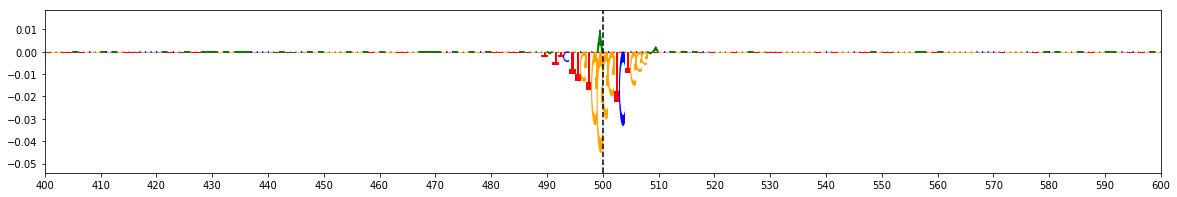


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 19   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.1724   ||  Center / 200bp: 0.529
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


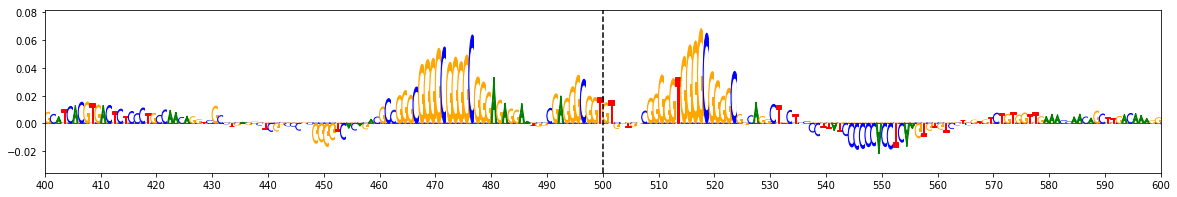

Noneffect Allele: C   ||  Explain Score: 0.9679   ||  Center / 200bp: 0.4815
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


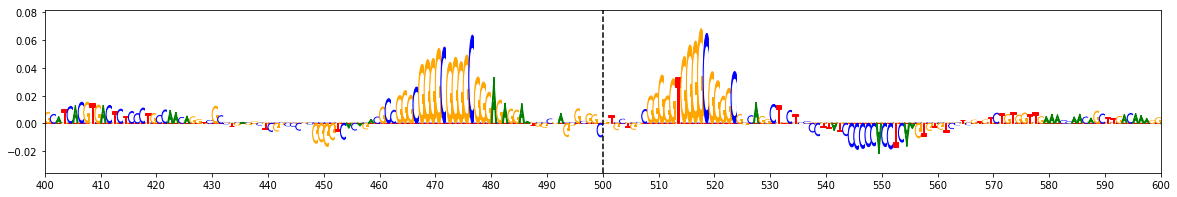

Allele Ratio : 1.2112   ||   Allele Difference : 0.2302  ||  ISM Score : 0.3822  ||  deltaSVM Score : 2.2832


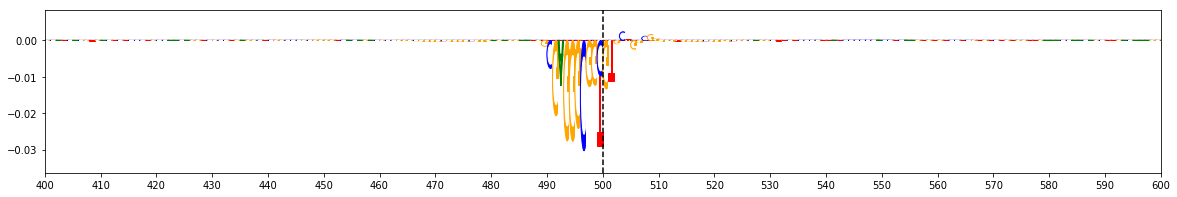


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2072369   ||    chr7 : 23106569 - 23106570   ||    Locus: 228   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  2.22E-03

Coloc:  True

Effect Allele: A   ||  Explain Score: 1.0334   ||  Center / 200bp: 0.5617
Effect Sequence: GCTGGCCTGACATCAGCTGC


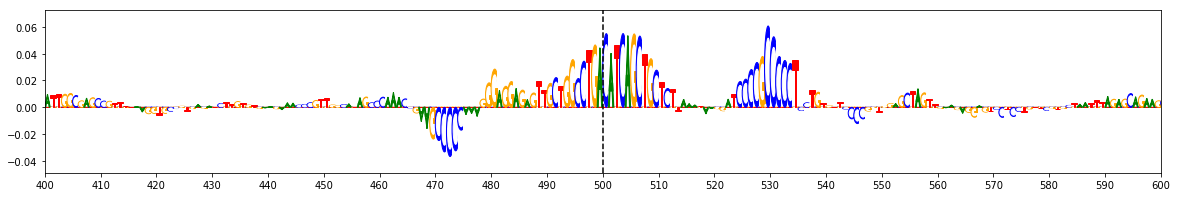

Noneffect Allele: G   ||  Explain Score: 0.9241   ||  Center / 200bp: 0.534
Noneffect Sequence: GCTGGCCTGGCATCAGCTGC


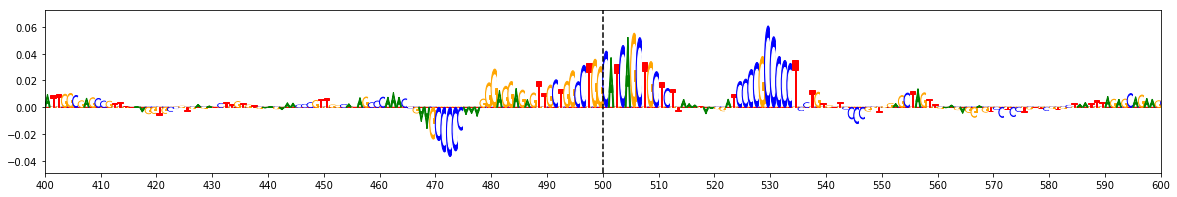

Allele Ratio : 1.1183   ||   Allele Difference : 0.1093  ||  ISM Score : 0.1698  ||  deltaSVM Score : 0.987


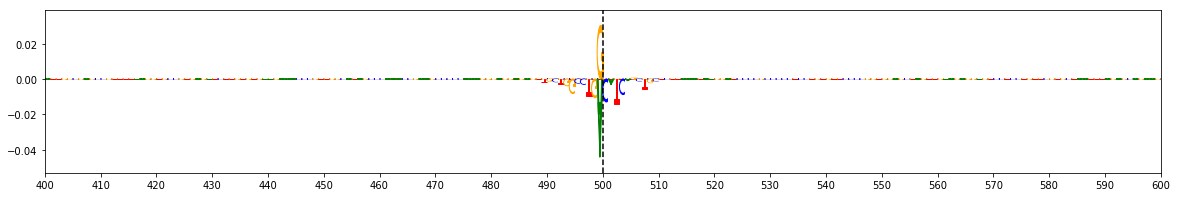


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 205   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.2652   ||  Center / 200bp: 0.3768
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


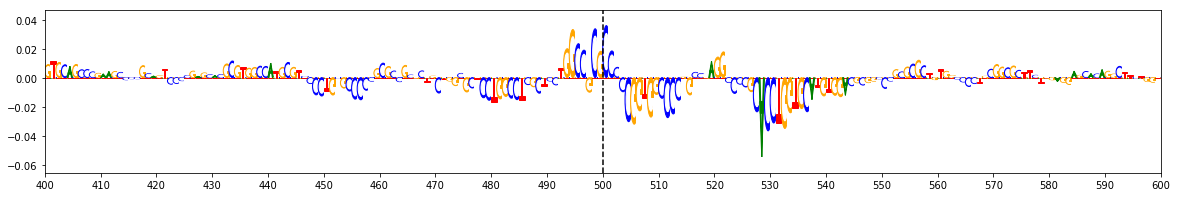

Noneffect Allele: A   ||  Explain Score: 0.1617   ||  Center / 200bp: 0.2663
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


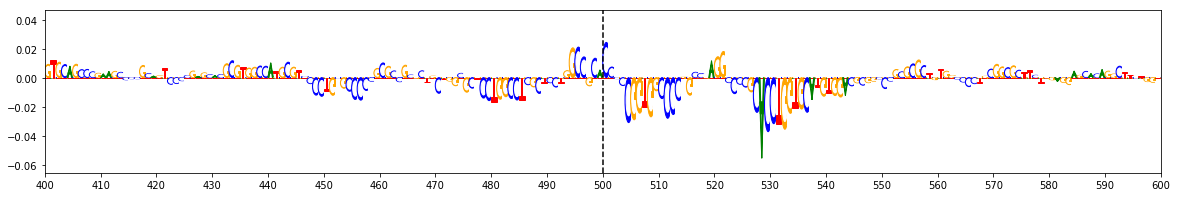

Allele Ratio : 1.6399   ||   Allele Difference : 0.1067  ||  ISM Score : 0.1738  ||  deltaSVM Score : 1.0386


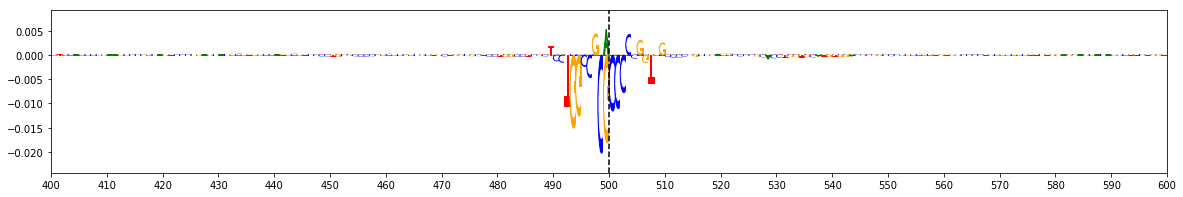


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3865444   ||    chr19 : 51224705 - 51224706   ||    Locus: 166   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  6.34E-09
Alzheimers_Kunkle_2019 		  3.93E-07
Alzheimers_Lambert_2013 	  5.12E-08

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.4103   ||  Center / 200bp: 0.3119
Effect Sequence: TAAACACCCAATGGATCTAG


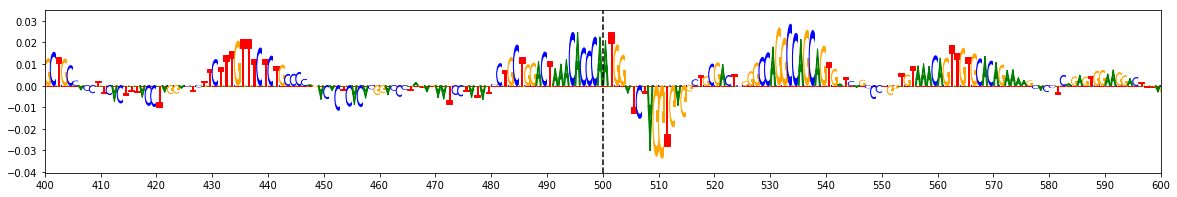

Noneffect Allele: C   ||  Explain Score: 0.2125   ||  Center / 200bp: 0.1902
Noneffect Sequence: TAAACACCCCATGGATCTAG


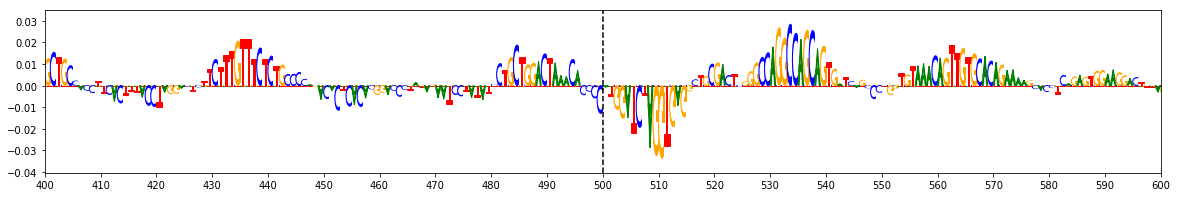

Allele Ratio : 1.9311   ||   Allele Difference : 0.2798  ||  ISM Score : 0.4372  ||  deltaSVM Score : 2.4796


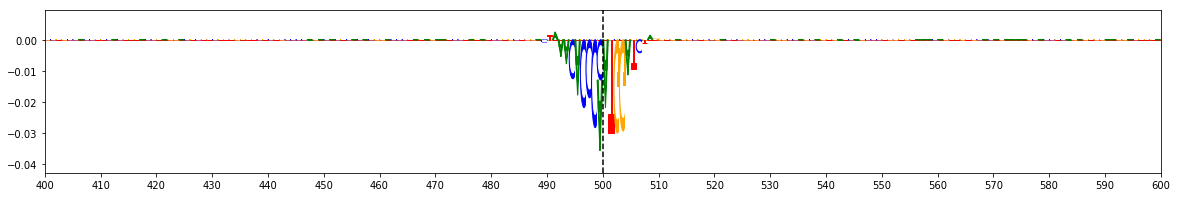


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2296887   ||    chr10 : 102245652 - 102245653   ||    Locus: 5   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.98E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.4428   ||  Center / 200bp: 0.343
Effect Sequence: GAAACAGGCTCCTTCTCTTC


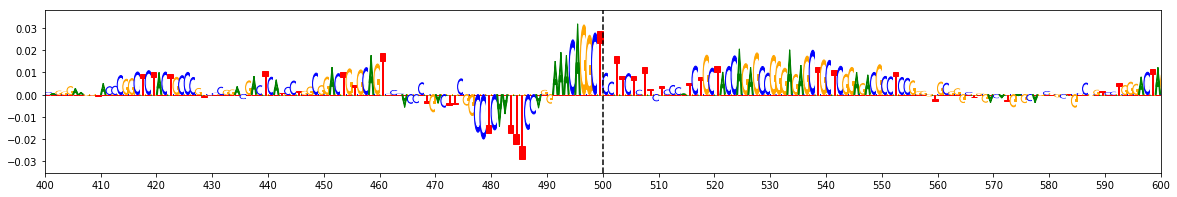

Noneffect Allele: C   ||  Explain Score: 0.2545   ||  Center / 200bp: 0.2308
Noneffect Sequence: GAAACAGGCCCCTTCTCTTC


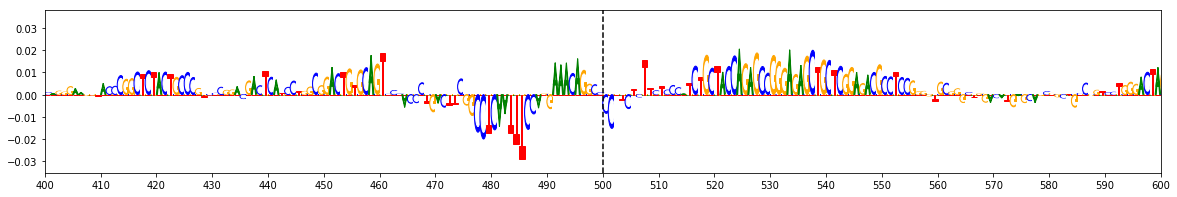

Allele Ratio : 1.7402   ||   Allele Difference : 0.2218  ||  ISM Score : 0.3454  ||  deltaSVM Score : 1.9745


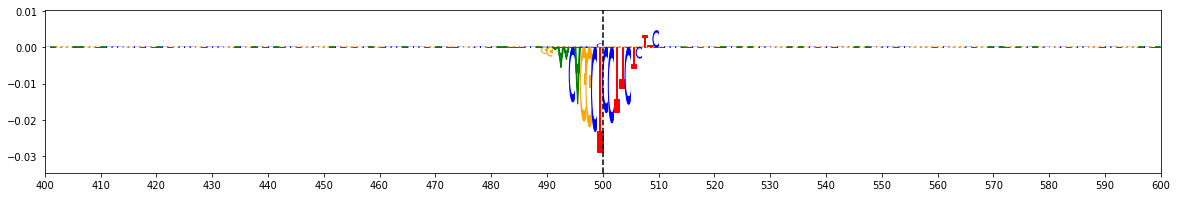


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6733839   ||    chr2 : 127135233 - 127135234   ||    Locus: 180   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.28E-29
Alzheimers_Kunkle_2019 		  4.02E-28
Alzheimers_Lambert_2013 	  1.66E-26

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.797   ||  Center / 200bp: 0.5411
Effect Sequence: TCTTAAAAATACCCTTTTCC


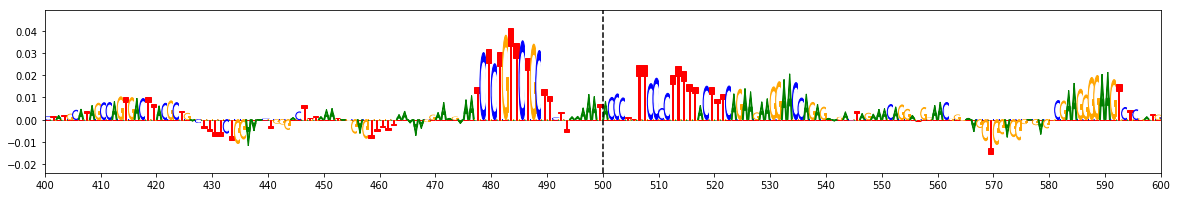

Noneffect Allele: C   ||  Explain Score: 0.7315   ||  Center / 200bp: 0.5208
Noneffect Sequence: TCTTAAAAACACCCTTTTCC


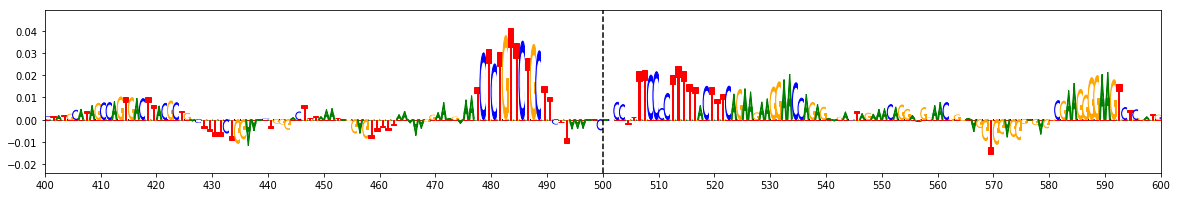

Allele Ratio : 1.0895   ||   Allele Difference : 0.0936  ||  ISM Score : 0.1423  ||  deltaSVM Score : 0.8174


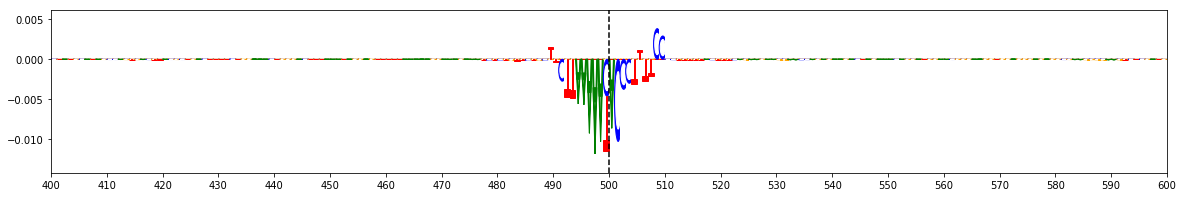


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10792265   ||    chr11 : 60333145 - 60333146   ||    Locus: 13   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  9.64E-09

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7886   ||  Center / 200bp: 0.541
Effect Sequence: GGAATAGTTGCCAGGCTGTG


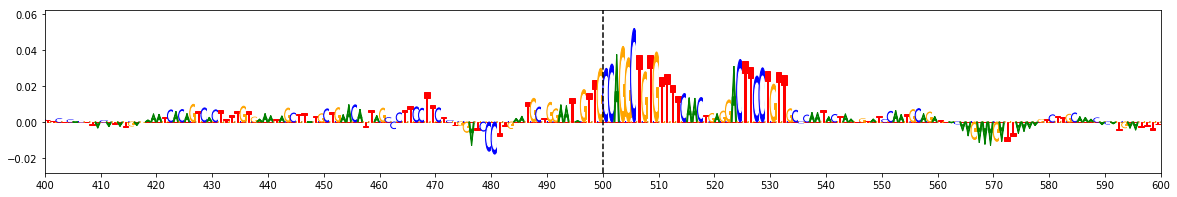

Noneffect Allele: A   ||  Explain Score: 0.7286   ||  Center / 200bp: 0.5213
Noneffect Sequence: GGAATAGTTACCAGGCTGTG


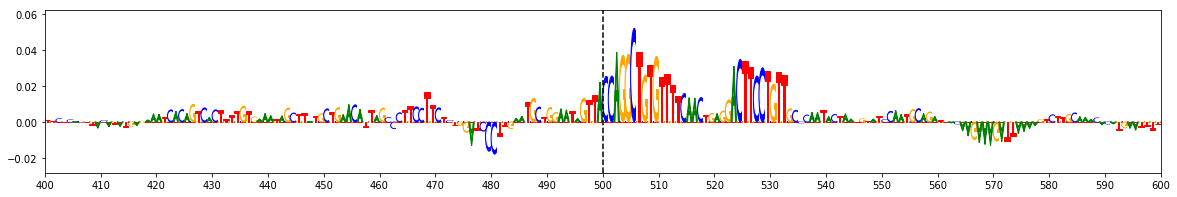

Allele Ratio : 1.0824   ||   Allele Difference : 0.06  ||  ISM Score : 0.0941  ||  deltaSVM Score : 0.5591


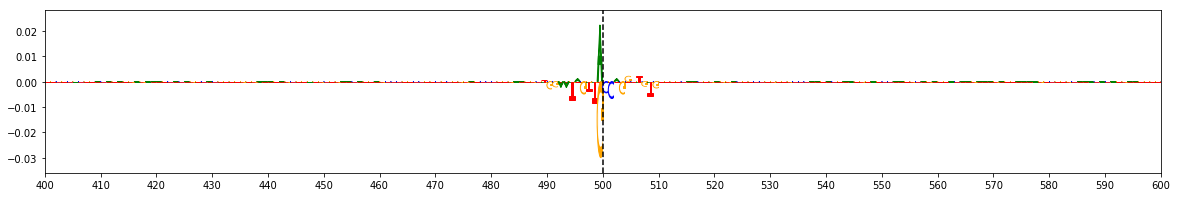


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs145480601   ||    chr3 : 52368659 - 52368660   ||    Locus: 193   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.45E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.924   ||  Center / 200bp: 0.4615
Effect Sequence: CCACCCGGCGGCCAGGCTTC


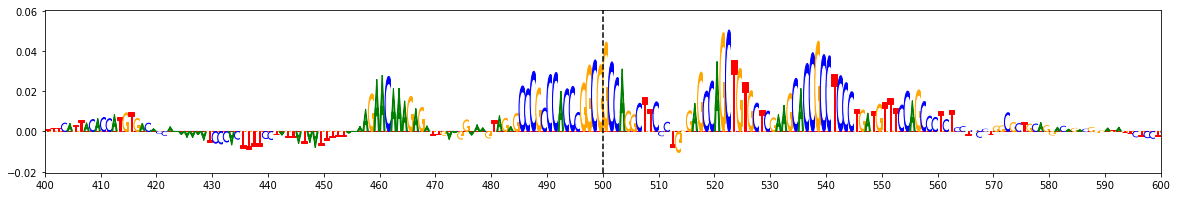

Noneffect Allele: A   ||  Explain Score: 0.731   ||  Center / 200bp: 0.4046
Noneffect Sequence: CCACCCGGCAGCCAGGCTTC


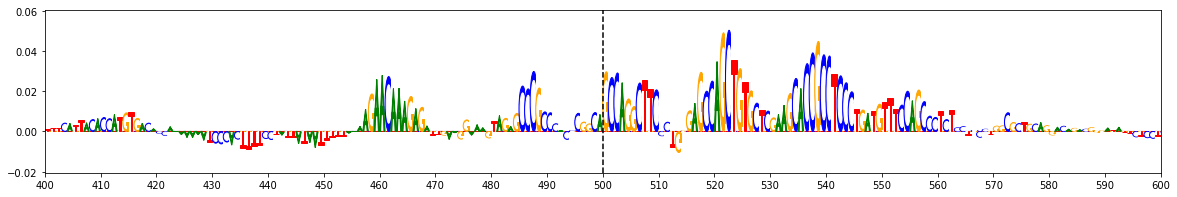

Allele Ratio : 1.2641   ||   Allele Difference : 0.1969  ||  ISM Score : 0.3086  ||  deltaSVM Score : 1.7879


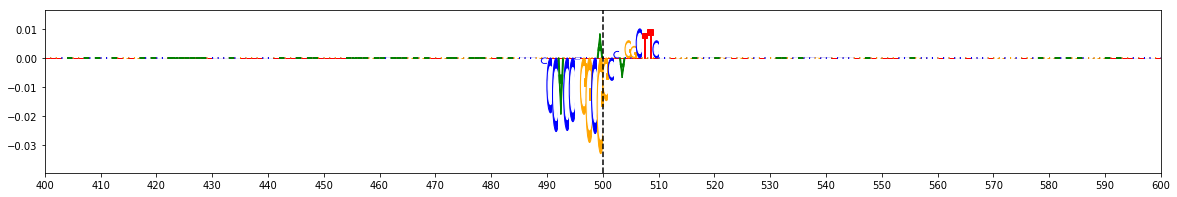


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6085343   ||    chr20 : 6006303 - 6006304   ||    Locus: 186   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.41E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.9906   ||  Center / 200bp: 0.5539
Effect Sequence: GCCGCTTGGGCTCCGGGAAC


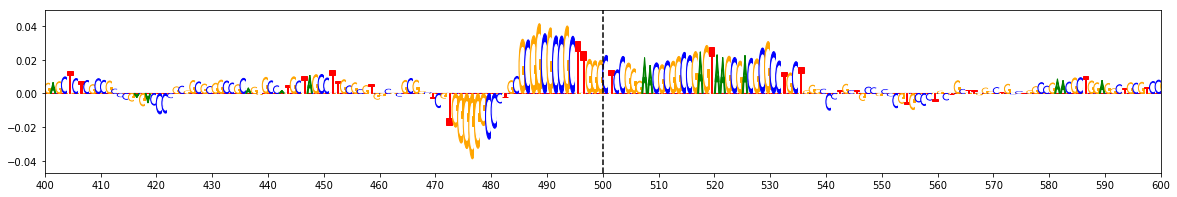

Noneffect Allele: A   ||  Explain Score: 0.9535   ||  Center / 200bp: 0.5432
Noneffect Sequence: GCCGCTTGGACTCCGGGAAC


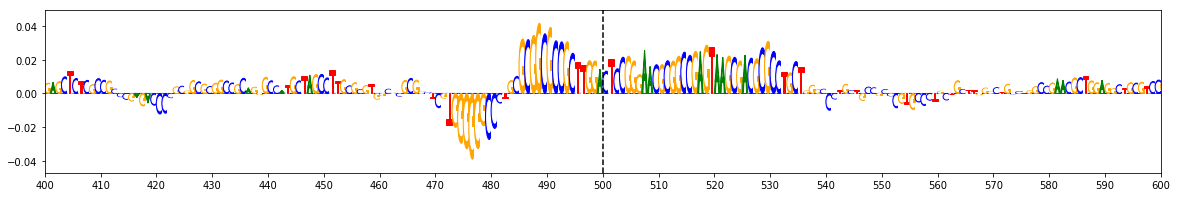

Allele Ratio : 1.0389   ||   Allele Difference : 0.038  ||  ISM Score : 0.0664  ||  deltaSVM Score : 0.3981


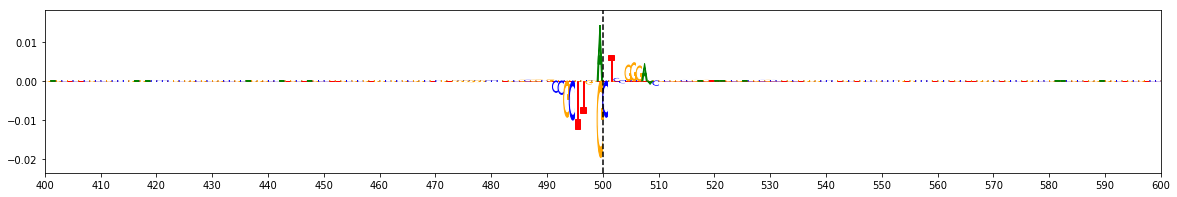


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()